In [1]:
import swan_vis as swan
import pandas as pd
import anndata
import numpy as np
from statsmodels.stats.multitest import multipletests
import scipy.stats as st
import scanpy as sc

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
# 6/17/21
# coloring for the report

In [3]:
sg = swan.SwanGraph()
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance_PB65.tsv'
sg.add_abundance(ab)
ab = 'data/chr11_and_Tcf3_talon_abundance_D12.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding transcriptome to the SwanGraph


Transforming to str index.
Transforming to str index.
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018 to SwanGraph.

Adding abundance for datasets D12 to SwanGraph.


In [4]:
obs_col = 'sample'
cmap = {'GM12878': 'plum', 'K562': 'goldenrod'}
sg.set_metadata_colors(obs_col, cmap)

In [7]:
sg.adata.uns['sample_colors']

['plum', 'goldenrod']

In [8]:
sg.adata.obs

,dataset,cluster,sample
index,,,
PB65_B017,PB65_B017,2,GM12878
PB65_B018,PB65_B018,2,GM12878
D12,D12,1,K562


In [17]:
obs_col = 'sample'

# set sample colors
gm_blue = 'plum'
k562_red = 'goldenrod'

obs_order = list(sg.adata.obs_names)

# sample type
sample_order = sg.adata.obs.loc[obs_order, 'sample']
sample_order = sample_order.unique().tolist()
c_dict = {'GM12878': gm_blue,
          'K562': k562_red}

sample_colors = [c_dict[s] for s in sample_order]
sg.adata.uns['{}_colors'.format(obs_col)] = sample_colors

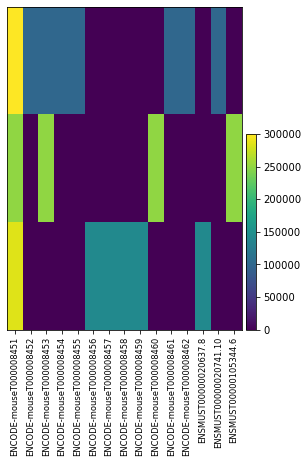

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0, 4.5, 0, 0.2])

In [9]:
# plot heatmap? 
var_names = sg.adata.var.index.tolist()
sg.adata.X = sg.adata.layers['tpm']
sc.pl.heatmap(sg.adata, var_names)

In [2]:
# 6/16/21 
# calculating tss abundance

In [3]:
sg = swan.SwanGraph()
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance_PB65.tsv'
sg.add_abundance(ab)
ab = 'data/chr11_and_Tcf3_talon_abundance_D12.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding transcriptome to the SwanGraph


Transforming to str index.
Transforming to str index.
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018 to SwanGraph.
hewwo?
                        PB65_B017  PB65_B018
ENCODE-mouseT000008451        3.0        1.0
ENCODE-mouseT000008452        1.0        0.0
ENCODE-mouseT000008453        1.0        1.0
ENCODE-mouseT000008454        1.0        0.0
ENCODE-mouseT000008455        1.0        0.0

Adding abundance for datasets D12 to SwanGraph.
hewwo?
                        D12  PB65_B017  PB65_B018
ENCODE-mouseT000008451  2.0        3.0        1.0
ENCODE-mouseT000008452  0.0        1.0        0.0
ENCODE-mouseT000008453  0.0        1.0        1.0
ENCODE-mouseT000008454  0.0        1.0        0.0
ENCODE-mouseT000008455  0.0        1.0        0.0


In [4]:
def create_end_adata(sg,kind):
    """
    Create a tss / tes-level adata object. Enables calculating tss / tes
    usage across samples.

    Parameters:
        kind (str): Choose from 'tss' or 'tes'
    """

    end_exp_df = swan.get_ends(sg.t_df, kind)

    # get a mergeable transcript expression df
    tid = sg.adata.var.index.tolist()
    obs = sg.adata.obs.index.tolist()
    data = sg.adata.layers['counts'].transpose()
    t_exp_df = pd.DataFrame(columns=obs, data=data, index=tid)
    cols = ['gid', 'gname']
    t_exp_df = t_exp_df.merge(sg.t_df[cols], left_index=True, right_index=True)
#     print(t_exp_df.head()) 

    # merge counts per transcript with end expression
    end_exp_df = end_exp_df.merge(t_exp_df, how='left',
        left_index=True, right_index=True)
    
    # sum across the same gene
    end_exp_df.reset_index(drop=True, inplace=True)
    end_exp_df = end_exp_df.groupby(['vertex_id', 'gid', 'gname']).sum()
    print(end_exp_df.head())
    

    # sort based on vertex id
    end_exp_df.sort_values(by='vertex_id', inplace=True, ascending=True)
    end_exp_df.reset_index(inplace=True)
    end_exp_df.index = end_exp_df.gid + '_' + end_exp_df.vertex_id.astype('str')
    end_exp_df.index.name = '{}_id'.format(kind)
#     end_exp_df['{}_id'.format(kind)] = end_exp_df.tid
#     end_exp_df.set_index(['gid', 'gname', 'vertex_id'], inplace=True)
    print(end_exp_df)

    # obs, var, and X tables for new data
    var_cols = ['vertex_id', 'gid', 'gname']
    var = end_exp_df[var_cols]
    end_exp_df.drop(var_cols, axis=1, inplace=True)
    X = end_exp_df.transpose().values
    obs = sg.adata.obs
    print(obs)
    print(obs.shape)
    print(X)
    print(X.shape)
    print(var.shape)
    print(var)

    if kind == 'tss':

        # create end-level adata object
        sg.tss_adata = anndata.AnnData(var=var, obs=obs, X=X)

        # add counts and tpm as layers
        sg.tss_adata.layers['counts'] = sg.tss_adata.X
        sg.tss_adata.layers['tpm'] = swan.calc_tpm(sg.tss_adata, sg.t_df).to_numpy()
        sg.tss_adata.layers['pi'] = swan.calc_pi(sg.tss_adata, sg.t_df)[0].to_numpy()

        if sg.has_abundance():

            # some cleanup for unstructured data
            sg.edge_adata.uns = sg.tss_adata.uns

In [5]:
create_end_adata(sg, 'tss')

                                                         PB65_B017  PB65_B018  \
vertex_id gid                    gname                                          
1         ENSMUSG00000020167.13  ENSMUSG00000020167.13         3.0        1.0   
6         ENSMUSG00000020167.13  ENSMUSG00000020167.13         1.0        0.0   
38        ENSMUSG00000020167.13  ENSMUSG00000020167.13         0.0        1.0   
57        ENSMUSG00000020457.12  ENSMUSG00000020457.12         2.0        1.0   
61        ENCODE-mouseG000002988 ENCODE-mouseG000002988        1.0        0.0   

                                                         D12  
vertex_id gid                    gname                        
1         ENSMUSG00000020167.13  ENSMUSG00000020167.13   2.0  
6         ENSMUSG00000020167.13  ENSMUSG00000020167.13   0.0  
38        ENSMUSG00000020167.13  ENSMUSG00000020167.13   0.0  
57        ENSMUSG00000020457.12  ENSMUSG00000020457.12   0.0  
61        ENCODE-mouseG000002988 ENCODE-mouseG00000298

ValueError: Value passed for key 'pi' is of incorrect shape. Values of layers must match dimensions (0, 1) of parent. Value had shape (3, 0) while it should have had (3, 11).

In [2]:
# 6/15/21
# calculating edge abundance


In [3]:
sg = swan.SwanGraph()
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance_PB65.tsv'
sg.add_abundance(ab)
ab = 'data/chr11_and_Tcf3_talon_abundance_D12.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding transcriptome to the SwanGraph


Transforming to str index.
Transforming to str index.
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018 to SwanGraph.

Adding abundance for datasets D12 to SwanGraph.


In [7]:
sg.edge_adata.layers['tpm']

array([[    0.        , 11904.76190476, 11904.76190476, 11904.76190476,
        35714.28571429, 11904.76190476, 11904.76190476,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        , 11904.76190476,
        11904.76190476, 23809.52380952, 23809.52380952, 11904.76190476,
        11904.76190476, 11904.76190476, 11904.76190476, 23809.52380952,
        23809.52380952, 23809.52380952, 23809.52380952, 23809.52380952,
        23809.52380952, 23809.52380952, 23809.52380952, 23809.52

In [ ]:
# sg.create_edge_adata(False)

In [6]:
print(sg.edge_adata.var.head())
print(sg.edge_adata.var.index.tolist()[:5])

         edge_id
edge_id         
96            96
98            98
95            95
94            94
97            97
['96', '98', '95', '94', '97']


In [7]:
sg.edge_adata.obs.head()

,dataset,cluster,sample
index,,,
PB65_B017,PB65_B017,2,GM12878
PB65_B018,PB65_B018,2,GM12878
D12,D12,1,K562


In [9]:
sg.edge_adata.X
sg.edge_adata.layers['tpm']

array([[    0.        , 11904.76190476, 11904.76190476, 11904.76190476,
        35714.28571429, 11904.76190476, 11904.76190476,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        , 11904.76190476,
        11904.76190476, 23809.52380952, 23809.52380952, 11904.76190476,
        11904.76190476, 11904.76190476, 11904.76190476, 23809.52380952,
        23809.52380952, 23809.52380952, 23809.52380952, 23809.52380952,
        23809.52380952, 23809.52380952, 23809.52380952, 23809.52

In [4]:
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173


In [5]:
def pivot_path_list(t_df, path_col):
    df = pd.DataFrame([[tid, x] for tid, path in zip(t_df.index, t_df[path_col]) for x in path])
    if path_col == 'path':
        df.columns = ['tid', 'edge_id']
    elif path_col == 'loc':
        df.columns = ['tid', 'loc_id']
#     df.set_index('tid', inplace=True)
    return df

In [6]:
# edge_exp_df = swan.pivot_path_list(sg.t_df, 'path')
# edge_exp_df.head()


In [7]:
tid = sg.adata.var.index.tolist()
obs = sg.adata.obs.index.tolist()
data = sg.adata.layers['counts'].transpose()
t_exp_df = pd.DataFrame(columns=obs, data=data, index=tid)
print(t_exp_df.head())


                        PB65_B017  PB65_B018  D12
ENCODE-mouseT000008451        3.0        1.0  2.0
ENCODE-mouseT000008452        1.0        0.0  0.0
ENCODE-mouseT000008453        1.0        1.0  0.0
ENCODE-mouseT000008454        1.0        0.0  0.0
ENCODE-mouseT000008455        1.0        0.0  0.0


In [8]:
# edge_exp_df.loc[edge_exp_df.edge_id == 20]


In [9]:
# merge with transcript expression data
edge_exp_df = swan.pivot_path_list(sg.t_df, 'path')
edge_exp_df = edge_exp_df.merge(t_exp_df, how='left', left_index=True, right_index=True)

print(edge_exp_df.head())


                        edge_id  PB65_B017  PB65_B018  D12
ENCODE-mouseT000008451       97        3.0        1.0  2.0
ENCODE-mouseT000008452       92        1.0        0.0  0.0
ENCODE-mouseT000008452       93        1.0        0.0  0.0
ENCODE-mouseT000008452       94        1.0        0.0  0.0
ENCODE-mouseT000008452       95        1.0        0.0  0.0


In [16]:
# groupby edge id and sum counts
# edge_t_df.reset_index(inplace=True)
edge_exp_df = edge_exp_df.groupby('edge_id').sum()

In [11]:
# # edge_t_df.set_index('edge_id', inplace=True)
# edge_exp_df.head()
# edge_exp_df.loc[20]


In [12]:
# edge_t_df.transpose().head()


In [13]:
# edge_t_df.head()


In [14]:
# sg.adata.obs


In [17]:
edge_exp_df = edge_exp_df.merge(sg.edge_df[['v1', 'v2']], 
    how='left', left_index=True, right_index=True)
edge_exp_df.sort_values(by=['v1', 'v2'], inplace=True)
edge_exp_df.drop(['v1', 'v2'], axis=1, inplace=True)
print(edge_exp_df.head())
print(edge_exp_df.index == sg.edge_df.index)


         PB65_B017  PB65_B018  D12
edge_id                           
96             0.0        1.0  0.0
98             1.0        0.0  0.0
95             1.0        1.0  0.0
94             1.0        1.0  0.0
97             3.0        1.0  2.0
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [18]:
edge_exp_df.head()

,PB65_B017,PB65_B018,D12
edge_id,,,
96,0.0,1.0,0.0
98,1.0,0.0,0.0
95,1.0,1.0,0.0
94,1.0,1.0,0.0
97,3.0,1.0,2.0


In [19]:
var = edge_exp_df.index.to_frame()
X = edge_exp_df.transpose().values
obs = sg.adata.obs
adata = anndata.AnnData(obs=obs, X=X, var=var)
adata.layers['counts'] = adata.X


Transforming to str index.


In [24]:
print(var)
print(var.dtypes)
print(var.index.tolist()[:5])

         edge_id
edge_id         
96            96
98            98
95            95
94            94
97            97
...          ...
23            23
22            22
21            21
20            20
49            49

[102 rows x 1 columns]
edge_id    int64
dtype: object
[96, 98, 95, 94, 97]


In [25]:
print(adata.var.index.tolist()[:5])
print(sg.edge_df.index.tolist()[:5])
print(adata.var.index.astype('int') == sg.edge_df.index)

['96', '98', '95', '94', '97']
[96, 98, 95, 94, 97]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [16]:
# # def calc_total_counts(adata, obs_col='dataset'):
# # 	"""
# # 	Calculate cumulative expression per adata entry based on condition given
# # 	by `obs_col`. Default column to use is `adata.obs` index column, `dataset`.

# # 	Parameters:
# # 		adata (anndata AnnData): Annotated data object from the SwanGraph
# # 		obs_col (str): Column name from adata.obs table to group on.
# # 			Default: 'dataset'

# # 	Returns:
# # 		df (pandas DataFrame): Pandas DataFrame where rows are the different
# # 			conditions from `obs_col` and the columns are transcript ids in the
# # 			SwanGraph, and values represent the cumulative counts per isoform
# # 			per condition.

# # 	"""
# # 	adata.X = adata.layers['counts']
# # 	df = pd.DataFrame(data=adata.X, index=adata.obs[obs_col].tolist(), \
# # 		columns=adata.var.index.tolist())

# # 	# add up values on condition (row)
# # 	df = df.groupby(level=0).sum()
# # 	# df = df.transpose()

# # 	return df

# def calc_tpm(adata, sg_df, obs_col='dataset'):
# 	"""
# 	Calculate the TPM per condition given by `obs_col`.
# 	Default column to use is `adata.obs` index column, `dataset`.

# 	Parameters:
# 		adata (anndata AnnData): Annotated data object from the SwanGraph
# 		sg_df (pandas DataFrame): Pandas DataFrame from SwanGraph that will
# 			be used to order the rows of resultant TPM DataFrame
# 		obs_col (str): Column name from adata.obs table to group on.
# 			Default: 'dataset'

# 	Returns:
# 		df (pandas DataFrame): Pandas datafrom where rows are the different
# 			conditions from `obs_col` and the columns are transcript ids in the
# 			SwanGraph, and values represent the TPM value per isoform per
# 			condition.
# 	"""

# 	# calculate cumulative counts across obs_col
# 	id_col = adata.var.index.name
# 	conditions = adata.obs[obs_col].unique().tolist()
# 	df = swan.calc_total_counts(adata, obs_col=obs_col)
# 	print(df.head())
# 	print(df.dtypes)
# 	df = df.transpose()
# 	print(df.head())
# 	print(df.dtypes)
#     # we use ints to index edges and locs
# 	if id_col == 'vertex_id' or id_col == 'edge_id':
# 		df.index = df.index.astype('int')
# 	print(df.index.tolist()[:5])

# 	# calculate tpm per isoform per condition
# 	tpm_cols = []
# 	for c in conditions:
# 		cond_col = '{}_tpm'.format(c)
# 		total_col = '{}_total'.format(c)
# 		df[total_col] = df[c].sum()
# 		df[cond_col] = (df[c]*1000000)/df[total_col]
# 		tpm_cols.append(cond_col)

# 	# formatting
# 	df.index.name = id_col
# 	df = df[tpm_cols]
# 	for col in tpm_cols:
# 		new_col = col[:-4]
# 		df.rename({col: new_col}, axis=1, inplace=True)

# 	# reorder columns like adata.obs
# 	df = df[adata.obs[obs_col].unique().tolist()]
# 	df = df.transpose()

# 	# reorder in adata.var / t_df order
# # 	print(df.head())
# # 	print(id_col)
# # 	print(sg_df.head())
# # 	print(len(df.columns))
# # 	print(len(sg_df[id_col].unique()))
# 	print(set(df.columns.tolist()) == set(sg_df[id_col].tolist()))
# 	print(df.columns.tolist()[:5])
# 	print(sg_df[id_col].tolist()[:5])
# 	df = df[sg_df[id_col].tolist()]

# 	return df

In [26]:
adata.var.head()

,edge_id
edge_id,
96,96
98,98
95,95
94,94
97,97


In [27]:
tpm_df = swan.calc_tpm(adata, sg.edge_df)

In [28]:
tpm_df.head()

edge_id,96,98,95,94,97,93,92,91,90,89,...,28,27,26,25,24,23,22,21,20,49
PB65_B017,0.000000,11904.761905,11904.761905,11904.761905,35714.285714,11904.761905,11904.761905,0.000000,0.000000,0.000000,...,23809.523810,23809.523810,23809.523810,23809.523810,23809.523810,11904.761905,11904.761905,11904.761905,11904.761905,0.000000
PB65_B018,12820.512821,0.000000,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,...,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,12820.512821,0.000000
D12,0.000000,0.000000,0.000000,0.000000,26666.666667,0.000000,0.000000,0.000000,0.000000,0.000000,...,26666.666667,26666.666667,26666.666667,26666.666667,26666.666667,26666.666667,26666.666667,26666.666667,13333.333333,13333.333333


In [17]:
adata.var.head()


,edge_id
edge_id,
0,0
1,1
2,2
3,3
4,4


In [18]:
adata.obs.head()


,dataset,cluster,sample
index,,,
PB65_B017,PB65_B017,2,GM12878
PB65_B018,PB65_B018,2,GM12878
D12,D12,1,K562


In [19]:
adata.X


array([[1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2.,
        1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        0., 3., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [17]:
for tid, _list in zip(sg.t_df.tid, sg.t_df.path):
    print(tid)
    print(_list)
    break

ENCODE-mouseT000008451
[97]


In [8]:
print(sg.t_df.dtypes)

tname       object
gid         object
gname       object
path        object
tid         object
novelty     object
loc_path    object
dtype: object


In [7]:
sg.t_df.loc[sg.t_df.path.str.contains('97')]

KeyError: "None of [Float64Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              nan, nan],\n             dtype='float64', name='tid')] are in the [index]"

In [4]:
for ind, entry in sg.edge_df.iterrows():
    
    # transcripts that use this edge
    
    
    

102


In [6]:
# 6/14/21

In [7]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_full.db')


Adding transcriptome to the SwanGraph


UnboundLocalError: local variable 't_df' referenced before assignment

In [ ]:
# 6/11/21
# idk


In [2]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_full.gtf')


Adding transcriptome to the SwanGraph


In [3]:
sg.t_df

,tname,gid,gname,path,tid,loc_path
tid,,,,,,
test1,test1_tname,test1_gid,test1_gname,"[0, 1, 2, 3, 4]",test1,"[0, 1, 2, 3, 4, 5]"
test2,test2_tname,test2_gid,test2_gname,"[5, 6, 7, 8, 9]",test2,"[12, 11, 10, 8, 7, 6]"
test3,test3_tname,test2_gid,test2_gname,"[5, 6, 13, 14, 9]",test3,"[12, 11, 10, 9, 7, 6]"
test4,test4_tname,test4_gid,test4_gname,[10],test4,"[6, 7]"
test5,test5_tname,test2_gid,test2_gname,"[5, 11, 12]",test5,"[12, 11, 8, 7]"


In [2]:
# 6/9/21
# browser path tests


Adding transcriptome to the SwanGraph


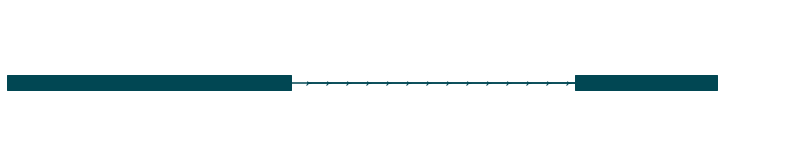

In [8]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_full.gtf')
sg.plot_transcript_path('test5', browser=True)

In [2]:
# 6/8/21 
# plotting tests


In [5]:
sg.t_df

,tname,gid,gname,path,tid,loc_path
tid,,,,,,
test1,test1_tname,test1_gid,test1_gname,"[0, 1, 2, 3, 4]",test1,"[0, 1, 2, 3, 4, 5]"
test2,test2_tname,test2_gid,test2_gname,"[5, 6, 7, 8, 9]",test2,"[12, 11, 10, 8, 7, 6]"
test3,test3_tname,test2_gid,test2_gname,"[5, 6, 13, 14, 9]",test3,"[12, 11, 10, 9, 7, 6]"
test4,test4_tname,test4_gid,test4_gname,[10],test4,"[6, 7]"
test5,test5_tname,test2_gid,test2_gname,"[5, 11, 12]",test5,"[12, 11, 8, 7]"


In [6]:
sg.edge_df

,v1,v2,strand,edge_type,edge_id
edge_id,,,,,
0,0,1,+,exon,0
1,1,2,+,intron,1
2,2,3,+,exon,2
3,3,4,+,intron,3
4,4,5,+,exon,4
10,6,7,+,exon,10
9,7,6,-,exon,9
8,8,7,-,intron,8
12,8,7,-,exon,12



Adding transcriptome to the SwanGraph


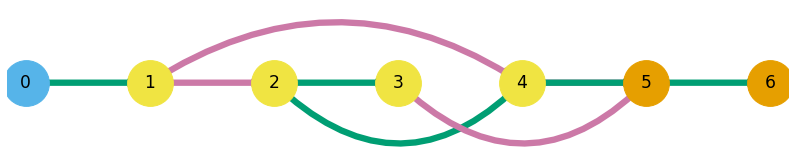

In [4]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_full.gtf')

sg.pg.new_gene(sg, 'test2_gid')
sg.pg.graph_type = 'swan'

sg.pg.new_swangraph()
sg.pg.calc_node_edge_styles()
sg.pg.plot_graph()


In [2]:
# 6/7/21 
# plotting tests

In [3]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_full.gtf')
beep = sg.subset_on_gene('test2_gid')


Adding transcriptome to the SwanGraph


In [4]:
beep.loc_df

,chrom,coord,vertex_id,internal,TSS,TES
vertex_id,,,,,,
0,chr2,100,0,False,True,False
1,chr2,80,1,True,False,False
2,chr2,75,2,True,False,False
3,chr2,65,3,True,False,False
4,chr2,60,4,True,False,False
5,chr2,50,5,True,False,True
6,chr2,45,6,False,False,True


In [6]:
ctrl_edge_df = pd.read_csv('../new_testing/files/plot_minus_gene_summary_edge_df.tsv', sep='\t')

In [8]:
ctrl_edge_df
ctrl_edge_df.drop(['v1_old', 'v2_old'], axis=1, inplace=True)
ctrl_edge_df = swan.create_dupe_index(ctrl_edge_df, 'edge_id')
ctrl_edge_df = swan.set_dupe_index(ctrl_edge_df, 'edge_id')
ctrl_edge_df

,strand,edge_type,v1,v2,color,line,edge_id
edge_id,,,,,,,
9,-,exon,5,6,exon,None,9
8,-,intron,4,5,intron,None,8
12,-,exon,4,5,exon,None,12
14,-,intron,3,5,intron,None,14
7,-,exon,2,4,exon,None,7
13,-,exon,2,3,exon,None,13
11,-,intron,1,4,intron,None,11
6,-,intron,1,2,intron,None,6
5,-,exon,0,1,exon,None,5


In [9]:
ctrl_loc_df = pd.read_csv('../new_testing/files/plot_minus_gene_summary_loc_df.tsv', sep='\t')

In [10]:
ctrl_loc_df

,vertex_id,chrom,coord,internal,TSS,TES,old_vertex_id,color,edgecolor
0,0,chr2,100,False,True,False,12,TSS,None
1,1,chr2,80,True,False,False,11,internal,None
2,2,chr2,75,True,False,False,10,internal,None
3,3,chr2,65,True,False,False,9,internal,None
4,4,chr2,60,True,False,False,8,internal,None
5,5,chr2,50,True,False,True,7,TES,None
6,6,chr2,45,False,False,True,6,TES,None


In [11]:
sg.pg.loc_df

,chrom,coord,vertex_id,internal,TSS,TES,color,edgecolor,linewidth
vertex_id,,,,,,,,,
0,chr2,100,0,False,True,False,TSS,None,None
1,chr2,80,1,True,False,False,internal,None,None
2,chr2,75,2,True,False,False,internal,None,None
3,chr2,65,3,True,False,False,internal,None,None
4,chr2,60,4,True,False,False,internal,None,None
5,chr2,50,5,True,False,True,TES,None,None
6,chr2,45,6,False,False,True,TES,None,None



Adding transcriptome to the SwanGraph
             tname        gid        gname               path    tid  \
tid                                                                    
test1  test1_tname  test1_gid  test1_gname    [0, 1, 2, 3, 4]  test1   
test2  test2_tname  test2_gid  test2_gname    [5, 6, 7, 8, 9]  test2   
test3  test3_tname  test2_gid  test2_gname  [5, 6, 13, 14, 9]  test3   
test4  test4_tname  test4_gid  test4_gname               [10]  test4   
test5  test5_tname  test2_gid  test2_gname        [5, 11, 12]  test5   

                    loc_path  
tid                           
test1     [0, 1, 2, 3, 4, 5]  
test2  [12, 11, 10, 8, 7, 6]  
test3  [12, 11, 10, 9, 7, 6]  
test4                 [6, 7]  
test5         [12, 11, 8, 7]  
         v1  v2 strand edge_type  edge_id
edge_id                                  
0         0   1      +      exon        0
1         1   2      +    intron        1
2         2   3      +      exon        2
3         3   4      +    int

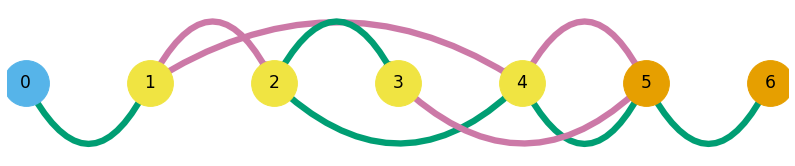

In [5]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_full.gtf')
print(sg.t_df.head())
print(sg.edge_df)
print(sg.loc_df)
sg.plot_graph('test2_gid')
print()
print(sg.pg.edge_df)
print(sg.pg.loc_df)

In [7]:
sg.edge_df.loc[sg.edge_df.strand == '+']

,v1,v2,strand,edge_type,edge_id
0,0,1,+,exon,0
1,1,2,+,intron,1
2,2,3,+,exon,2
3,3,4,+,intron,3
4,4,5,+,exon,4
10,6,7,+,exon,10



Adding transcriptome to the SwanGraph
                         tname                    gid                  gname  \
tid                                                                            
ENSMUST00000020637.8  Canx-001  ENSMUSG00000020368.14  ENSMUSG00000020368.14   
ENSMUST00000146979.1  Canx-003  ENSMUSG00000020368.14  ENSMUSG00000020368.14   
ENSMUST00000153068.1  Canx-002  ENSMUSG00000020368.14  ENSMUSG00000020368.14   
ENSMUST00000155801.1  Canx-004  ENSMUSG00000020368.14  ENSMUSG00000020368.14   
ENSMUST00000179865.6  Canx-201  ENSMUSG00000020368.14  ENSMUSG00000020368.14   

                                                                   path  \
tid                                                                       
ENSMUST00000020637.8  [0, 29, 30, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...   
ENSMUST00000146979.1               [32, 21, 22, 23, 24, 25, 26, 27, 33]   
ENSMUST00000153068.1                                       [34, 23, 35]   
ENSMUST00000155801.1     

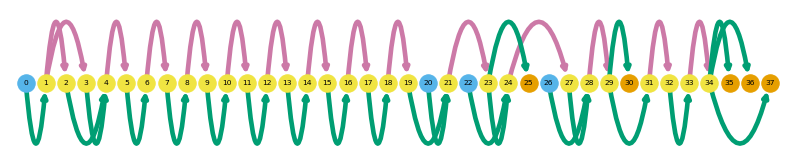

In [4]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/Canx.gtf')
print(sg.t_df.head())
print(sg.edge_df.head())

sg.plot_graph('ENSMUSG00000020368.14')

In [4]:
# 6/4/21
# graph.py tests

In [11]:
# has_abundnace
sg = swan.SwanGraph()
obs = ['sample1']
var = ['gene1']
X = np.array([[0]])
sg.adata = anndata.AnnData(var=var, obs=obs, X=X)
print(sg.adata.obs.head())
print(sg.adata.var.head())
print(sg.adata.X)

         0
0  sample1
       0
0  gene1
[[0.]]


In [2]:
# 6/2/21
# graph.py tests

In [3]:
# dfs_to_dicts
sg = swan.SwanGraph()

# loc
data = [[0, 'chr3', 20],
     [1, 'chr1', 500],
     [2, 'chr1', 20]]
cols = ['vertex_id', 'chrom', 'coord']
sg.loc_df = pd.DataFrame(data=data, columns=cols)
sg.loc_df = swan.set_dupe_index(sg.loc_df, 'vertex_id')

# edge
data = [[0, 0, 1],
        [1, 1, 2],
        [2, 0, 2]]
cols = ['edge_id', 'v1', 'v2']
sg.edge_df = pd.DataFrame(data=data, columns=cols)
sg.edge_df = swan.set_dupe_index(sg.edge_df, 'edge_id')

# t
data = [[0, [0,1], [0,1,2]],
        [1, [2], [0,2]]]
cols = ['tid', 'path', 'loc_path']
sg.t_df = pd.DataFrame(data=data, columns=cols)
sg.t_df = swan.set_dupe_index(sg.t_df, 'tid')

print(sg.t_df)
print(sg.edge_df)
print(sg.loc_df)

       path   loc_path
tid                   
0    [0, 1]  [0, 1, 2]
1       [2]     [0, 2]
         v1  v2
edge_id        
0         0   1
1         1   2
2         0   2
          chrom  coord
vertex_id             
0          chr3     20
1          chr1    500
2          chr1     20


In [4]:
sg.dicts_to_dfs()

TypeError: 'numpy.ndarray' object is not callable

In [2]:
# 6/1/20
# todo - add get_loc_path checks etc - done
# todo - add find_ir_genes, find_es_genes - done

In [18]:
sg = swan.SwanGraph()
sg.annotation = True

# t_df
data = [[0, [0,1,2,3,4], True, 'g1', 't1'],
        [1, [0,5,4], False, 'g1', 't2']]
cols = ['vertex_id', 'path', 'annotation', 'gid', 'tid']
sg.t_df = pd.DataFrame(data=data, columns=cols)

# edge
data = [[0, 'exon', True, 0, 1],
        [1, 'intron', True, 1, 2],
        [2, 'exon', True, 2, 3],
        [3, 'intron', True, 3, 4],
        [4, 'exon', True, 4, 5],
        [5, 'intron', False, 1, 4]]
cols = ['edge_id', 'edge_type', 'annotation', 'v1', 'v2']
sg.edge_df = pd.DataFrame(data=data, columns=cols)

# loc
data = [0,1,2,3,4,5]
cols = ['vertex_id']
sg.loc_df = pd.DataFrame(data=data, columns=cols)

ctrl_gids = ['g1']
ctrl_tids = ['t2']
ctrl_edges = [5]

sg.get_loc_path()
sg.create_graph_from_dfs()

In [ ]:
"""
Finds all unique genes containing novel exon skipping events.
Requires that an annotation has been added to the SwanGraph.

Returns:
    es_genes (list of str): A list of gene ids from the SwanGraph with
        at least one novel exon skipping event
    es_transcripts (list of str): A list of transcript ids from the
        SwanGraph with at least one novel exon skipping event
    es_edges (list of tuples): A list of intronic edges in the
        SwanGraph that skip at least one exonic edge
"""

# get only novel edges
if 'annotation' not in sg.edge_df.columns:
    raise Exception('Cannot find novel IR events without '
        'annotation in SwanGraph.')

edge_ids = sg.edge_df.loc[ \
    (sg.edge_df.annotation == False)& \
    (sg.edge_df.edge_type == 'intron'), 'edge_id']
print('Analyzing {} intronic edges for ES'.format(len(edge_ids)))

# get subset of transcripts that are novel to look for ir edges in
nt_df = sg.t_df.loc[sg.t_df.annotation == False]

# for each edge, see if the subgraph between the edge vertices
# contains an exonic edge
es_edges = []
es_genes = []
es_transcripts = []
for eid in edge_ids:
    # subgraph consisting of all nodes between the candidate
    # exon-skipping edge coords in order and its edges
    entry = sg.edge_df.loc[eid]
    v1 = entry.v1
    v2 = entry.v2
    sub_nodes = [i for i in range(v1+1,v2)]
    sub_G = sg.G.subgraph(sub_nodes)
    sub_edges = list(sub_G.edges())
    sg.edge_df['tuple_edge_id'] = sg.edge_df[['v1', 'v2']].apply(tuple, axis=1)
    sub_edges = sg.edge_df.loc[sg.edge_df.tuple_edge_id.isin(sub_edges)]
    sg.edge_df.drop('tuple_edge_id', axis=1, inplace=True)

    # find edges that are exonic; if there are none, this is not
    # an exon-skipping edge
    sub_edges = sub_edges.loc[sub_edges.edge_type == 'exon']

    if len(sub_edges.index) > 0:

        # transcripts that contain the candidate exon-skipping edge
        skip_t_df = nt_df[[eid in path for path in nt_df.path.values.tolist()]]

        # circumvent the ISM bug
        if len(skip_t_df) == 0:
            continue

        # does at least one of the skipped exons belong
        # to the same gene as the skipping edge?
        else:
            # genes that contain the candidate exon-skipping edge
            skip_genes = skip_t_df.gid.values.tolist()
            skip_g_df = sg.t_df.loc[sg.t_df.gid.isin(skip_genes)]

            # check if the skipped edges are in one of the
            # exon-skipping genes (wow this is confusing)
            for gid in skip_genes:
                if gid in es_genes: continue
                for skip_eid in sub_edges.index:
                    # transcripts with the exons that are skipped
                    temp_df = cand_g_df[[skip_eid in path for path in cand_g_df.path.values.tolist()]]
                    tids = skip_t_df.tid.tolist()
                    if len(temp_df.index) > 0:
                        es_edges.append(eid)
                        es_genes.append(gid)
                        es_transcripts.extend(tids)

# drop tuple from edge_df
print(sg.edge_df.head())
sg.edge_df.drop('tuple_edge_id', axis=1, inplace=True)

es_genes = list(set(es_genes))
es_transcripts = list(set(es_transcripts))
es_edges = list(set(es_edges))

print('Found {} novel es events in {} transcripts.'.format(len(es_edges),
    len(es_transcripts)))

In [3]:
# fix find_ir_genes
sg = swan.SwanGraph()
sg.annotation = True

# t_df
data = [[0, [0,1,2], True, 'g1', 't1'],
        [1, [3], False, 'g1', 't2']]
cols = ['vertex_id', 'path', 'annotation', 'gid', 'tid']
sg.t_df = pd.DataFrame(data=data, columns=cols)

# edge
data = [[0, 'exon', True, 0, 1],
        [1, 'intron', True, 1, 2],
        [2, 'exon', True, 2, 3],
        [3, 'exon', False, 0, 3]]
cols = ['edge_id', 'edge_type', 'annotation', 'v1', 'v2']
sg.edge_df = pd.DataFrame(data=data, columns=cols)

# loc
data = [0,1,2,3]
cols = ['vertex_id']
sg.loc_df = pd.DataFrame(data=data, columns=cols)

ctrl_edges = [3]
ctrl_tids = ['t2']
ctrl_gids = ['g1']

sg.get_loc_path()
sg.create_graph_from_dfs()

In [17]:
"""
Finds all unique genes containing novel intron retention events.
Requires that an annotation has been added to the SwanGraph.

Returns:
    ir_genes (list of str): A list of gene ids from the SwanGraph with
        at least one novel intron retention event
    ir_transcripts (list of str): A list of transcript ids from the
        SwanGraph with at least one novel intron retention event
    ir_edges (list of tuples): A list of exonic edges in the
        SwanGraph that retain at least one intronic edge
"""

# get only novel edges
if 'annotation' not in sg.edge_df.columns:
    raise Exception('Cannot find novel IR events without '
        'annotation in SwanGraph.')

edge_ids = sg.edge_df.loc[ \
    (sg.edge_df.annotation == False)& \
    (sg.edge_df.edge_type == 'exon'), 'edge_id']
print('Analyzing {} exonic edges for IR'.format(len(edge_ids)))

# get subset of transcripts that are novel to look for ir edges in
nt_df = sg.t_df.loc[sg.t_df.annotation == False]

# for each edge, see if the subgraph between the edge vertices
# contains an exonic edge
ir_edges = []
ir_genes = []
ir_transcripts = []
for i, eid in enumerate(edge_ids):
    entry = sg.edge_df.loc[eid]
    v1 = entry.v1
    v2 = entry.v2
    sub_nodes = [i for i in range(v1+1,v2)]
    sub_G = sg.G.subgraph(sub_nodes)

    # need way to get this working, bc (v1,v2) ind does not work anymore
    sub_edges = list(sub_G.edges())
    sg.edge_df['tuple_edge_id'] = sg.edge_df[['v1', 'v2']].apply(tuple, axis=1)
    sub_edges = sg.edge_df.loc[sg.edge_df.tuple_edge_id.isin(sub_edges)]
    
    # find edges that are intronic; if there are none, this is not
    # an intron-retaining edge
    sub_edges = sub_edges.loc[sub_edges.edge_type == 'intron']

    if len(sub_edges.index) > 0:

        # transcripts that contain the exon-skipping edge
        cand_t_df = nt_df[[eid in path for path in nt_df.path.values.tolist()]]

        # circumvent the ISM bug
        if len(cand_t_df) == 0:
            continue

        # does at least one of the retained introns belong
        # to the same gene as the retaining edge?
        else:
            # genes that contain the intron-retaining edge edge
            cand_genes = cand_t_df.gid.values.tolist()
            cand_g_df = sg.t_df.loc[sg.t_df.gid.isin(cand_genes)]

            # check if the retained edges are in one of the
            # intron-retaining genes (wow this is confusing)
            for gid in cand_genes:
                if gid in ir_genes: continue
                for cand_eid in sub_edges.index:
                    temp_df = cand_g_df[[cand_eid in path for path in cand_g_df.path.values.tolist()]]
                    tids = cand_t_df.tid.tolist()
                    if len(temp_df.index) > 0:
                        ir_edges.append(eid)
                        ir_genes.append(gid)
                        ir_transcripts.extend(tids)

ir_genes = list(set(ir_genes))
ir_transcripts = list(set(ir_transcripts))
ir_edges = list(set(ir_edges))

print('Found {} novel ir events from {} transcripts.'.format(len(ir_genes),
    len(ir_transcripts)))

Analyzing 1 exonic edges for IR
Found 1 novel ir events from 1 transcripts.


In [15]:
print(ir_genes)
print(ir_transcripts)
print(ir_edges)

['g1']
['t2']
[3]


In [11]:
nt_df.path.values.tolist()

[[3]]

In [17]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_full.gtf')

print(sg.t_df.head())
print(sg.edge_df.head())
print(sg.loc_df)


Adding transcriptome to the SwanGraph
             tname        gid        gname               path    tid
test1  test1_tname  test1_gid  test1_gname    [0, 1, 2, 3, 4]  test1
test2  test2_tname  test2_gid  test2_gname    [5, 6, 7, 8, 9]  test2
test4  test4_tname  test4_gid  test4_gname               [10]  test4
test5  test5_tname  test2_gid  test2_gname        [5, 11, 12]  test5
test3  test3_tname  test2_gid  test2_gname  [5, 6, 13, 14, 9]  test3
  v1 v2 strand edge_type edge_id
0  0  1      +      exon       0
1  1  4      +    intron       1
2  4  5      +      exon       2
3  5  2      +    intron       3
4  2  3      +      exon       4
   chrom coord vertex_id
0   chr1     1         0
1   chr1    20         1
2   chr1    35         2
3   chr1    40         3
4   chr1    25         4
5   chr1    30         5
6   chr2   100         6
7   chr2    80         7
8   chr2    50         8
9   chr2    45         9
10  chr2    75        10
11  chr2    60        11
12  chr2    65        12

In [18]:
def get_transcript_loc_path(path, edge_df):
    start_v1 = [edge_df.loc[path[0], 'v1']]
    v2s = edge_df.loc[path, 'v2'].tolist()
    loc_path = start_v1+v2s
    return loc_path

sg.t_df['loc_path'] = sg.t_df.apply(lambda x: \
    get_transcript_loc_path(x.path, sg.edge_df), axis=1)

In [20]:
sg.t_df.head()

,tname,gid,gname,path,tid,loc_path
test1,test1_tname,test1_gid,test1_gname,"[0, 1, 2, 3, 4]",test1,"[0, 1, 4, 5, 2, 3]"
test2,test2_tname,test2_gid,test2_gname,"[5, 6, 7, 8, 9]",test2,"[6, 7, 10, 11, 8, 9]"
test4,test4_tname,test4_gid,test4_gname,[10],test4,"[9, 8]"
test5,test5_tname,test2_gid,test2_gname,"[5, 11, 12]",test5,"[6, 7, 11, 8]"
test3,test3_tname,test2_gid,test2_gname,"[5, 6, 13, 14, 9]",test3,"[6, 7, 10, 12, 8, 9]"


In [16]:
path = [0, 1, 2, 3, 4]
start_v1 = [sg.edge_df.loc[path[0], 'v1']]
v2s = sg.edge_df.loc[path, 'v2'].tolist()
loc_path = start_v1+v2s

print(loc_path)

[0, 1, 4, 5, 2, 3]


In [ ]:
sg['loc_path']

In [6]:
sg = swan.SwanGraph()
sg.add_transcriptome('../new_testing/files/test_novel.gtf')
sg.add_annotation('../new_testing/files/test_known.gtf')
# sg.add_transcriptome('../new_testing/files/test_novel.gtf')

edge_df = sg.add_edge_coords()


Adding transcriptome to the SwanGraph

Adding annotation to the SwanGraph


In [7]:
sg.t_df

,tname,gid,gname,path,tid
test4,test4_tname,test2_gid,test2_gname,"[0, 1, 2, 3, 4]",test4
test5,test5_tname,test2_gid,test2_gname,"[0, 5, 6]",test5
test3,test3_tname,test2_gid,test2_gname,"[0, 1, 7, 8, 4]",test3
test1,test1_tname,test1_gid,test1_gname,"[9, 10, 11, 12, 13]",test1
test2,test2_tname,test2_gid,test2_gname,"[0, 1, 7, 8, 4]",test2


In [8]:
edge_df

,v1,v2,strand,edge_type,edge_id,chrom,v1_coord,vertex_id_x,v2_coord,vertex_id_y
0,0,1,-,exon,0,chr2,100,0,80,1
1,1,4,-,intron,1,chr2,80,1,75,4
2,4,5,-,exon,2,chr2,75,4,65,5
3,5,2,-,intron,3,chr2,65,5,50,2
4,2,3,-,exon,4,chr2,50,2,45,3
5,1,6,-,intron,5,chr2,80,1,60,6
6,6,2,-,exon,6,chr2,60,6,50,2
7,4,6,-,exon,7,chr2,75,4,60,6
8,6,2,-,intron,8,chr2,60,6,50,2
9,7,8,+,exon,9,chr1,1,7,20,8


In [9]:
sg.loc_df

,chrom,coord,vertex_id
0,chr2,100,0
1,chr2,80,1
2,chr2,50,2
3,chr2,45,3
4,chr2,75,4
5,chr2,65,5
6,chr2,60,6
7,chr1,1,7
8,chr1,20,8
9,chr1,35,9


#### test - create_dfs - swangraph with data, duplicate transcript being added
* also tests that old data (novelty in this case) is not overwritten

In [4]:
transcripts, exons = get_test_transcript_exon_dicts()
sg = swan.SwanGraph()

# add dummy data

# loc_df - format
loc_df = pd.read_csv('data/test_preexisting_loc_df.tsv', sep='\t')
loc_df.set_index('vertex_id_index', inplace=True)
loc_df.index.name = 'vertex_id'

# edge_df - format and remove the columns that are there 
# just for debugging purposes
edge_df = pd.read_csv('data/test_preexisting_edge_df.tsv', sep='\t')
edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
edge_df.set_index('edge_id_index', inplace=True)
edge_df.index.name = 'edge_id'

# t_df - remove and reformat columns that are there for debugging
t_df = pd.read_csv('data/test_preexisting_t_df.tsv', sep='\t')
t_df.set_index('tid_index', inplace=True)
t_df.index.name = 'tid'
t_df.drop(['loc_path'], axis=1, inplace=True)
t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
t_df['path'] = t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)
t_df = t_df[t_df.columns]

sg.loc_df = loc_df
sg.edge_df = edge_df
sg.t_df = t_df

loc_df, edge_df, t_df = sg.create_dfs(transcripts, exons, False)


# control data

# loc_df - format
ctrl_loc_df = pd.read_csv('data/test_preexisting_result_loc_df.tsv', sep='\t')
ctrl_loc_df.set_index('vertex_id_index', inplace=True)
ctrl_loc_df.index.name = 'vertex_id'

# edge_df - format and remove the columns that are there 
# just for debugging purposes
ctrl_edge_df = pd.read_csv('data/test_preexisting_result_edge_df.tsv', sep='\t')
ctrl_edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
ctrl_edge_df.set_index('edge_id_index', inplace=True)
ctrl_edge_df.index.name = 'edge_id'

# t_df - remove and reformat columns that are there for debugging
ctrl_t_df = pd.read_csv('data/test_preexisting_result_t_df.tsv', sep='\t')
ctrl_t_df.set_index('tid_index', inplace=True)
ctrl_t_df.index.name = 'tid'
ctrl_t_df.drop(['loc_path'], axis=1, inplace=True)
ctrl_t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
ctrl_t_df['path'] = ctrl_t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)
ctrl_t_df = ctrl_t_df[t_df.columns]

# remove novelty for entries that are new 
new_tids = ['test1', 'test3', 'test4', 'test5']
ctrl_t_df.loc[ctrl_t_df.tid.isin(new_tids), 'novelty'] = 'Undefined'

# sort all values by their IDs
loc_df.sort_index(inplace=True)
edge_df.sort_index(inplace=True)
t_df.sort_index(inplace=True)
ctrl_loc_df.sort_index(inplace=True)
ctrl_edge_df.sort_index(inplace=True)
ctrl_t_df.sort_index(inplace=True)

# bc I'm dumb, convert to integers
loc_df.coord = loc_df.coord.astype('int')

# print('test')
# print(loc_df)
# print('control')
# print(ctrl_loc_df)
print(ctrl_loc_df == loc_df)

# print('test')
# print(edge_df)
# print('control')
# print(ctrl_edge_df)
print(ctrl_edge_df == edge_df)

# print('test')
# print(t_df)
# print('control')
# print(ctrl_t_df)
print(ctrl_t_df == t_df)

# test_paths = t_df.path.tolist()
# ctrl_paths = ctrl_t_df.path.tolist()
# for t, c in zip(test_paths, ctrl_paths):
#     pass

           chrom  coord  vertex_id
vertex_id                         
0           True   True       True
1           True   True       True
2           True   True       True
3           True   True       True
4           True   True       True
5           True   True       True
6           True   True       True
7           True   True       True
8           True   True       True
9           True   True       True
10          True   True       True
11          True   True       True
12          True   True       True
           v1    v2  strand  edge_type  edge_id
edge_id                                        
0        True  True    True       True     True
1        True  True    True       True     True
2        True  True    True       True     True
3        True  True    True       True     True
4        True  True    True       True     True
5        True  True    True       True     True
6        True  True    True       True     True
7        True  True    True       True     

#### test - create_dfs - swangraph with data, mixed novelty content

In [4]:
transcripts, exons = get_test_transcript_exon_dicts()

# to do - remove transcript that's already there
sg = swan.SwanGraph()

# add dummy data

# loc_df - format
loc_df = pd.read_csv('data/test_preexisting_loc_df.tsv', sep='\t')
loc_df.set_index('vertex_id_index', inplace=True)
loc_df.index.name = 'vertex_id'

# edge_df - format and remove the columns that are there 
# just for debugging purposes
edge_df = pd.read_csv('data/test_preexisting_edge_df.tsv', sep='\t')
edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
edge_df.set_index('edge_id_index', inplace=True)
edge_df.index.name = 'edge_id'

# t_df - remove and reformat columns that are there for debugging
t_df = pd.read_csv('data/test_preexisting_t_df.tsv', sep='\t')
t_df.set_index('tid_index', inplace=True)
t_df.index.name = 'tid'
t_df.drop(['loc_path'], axis=1, inplace=True)
t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
t_df['path'] = t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)
t_df = t_df[t_df.columns]

sg.loc_df = loc_df
sg.edge_df = edge_df
sg.t_df = t_df

loc_df, edge_df, t_df = sg.create_dfs(transcripts, exons, False)


# control data

# loc_df - format
ctrl_loc_df = pd.read_csv('data/test_preexisting_result_loc_df.tsv', sep='\t')
ctrl_loc_df.set_index('vertex_id_index', inplace=True)
ctrl_loc_df.index.name = 'vertex_id'

# edge_df - format and remove the columns that are there 
# just for debugging purposes
ctrl_edge_df = pd.read_csv('data/test_preexisting_result_edge_df.tsv', sep='\t')
ctrl_edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
ctrl_edge_df.set_index('edge_id_index', inplace=True)
ctrl_edge_df.index.name = 'edge_id'

# t_df - remove and reformat columns that are there for debugging
ctrl_t_df = pd.read_csv('data/test_preexisting_result_t_df.tsv', sep='\t')
ctrl_t_df.set_index('tid_index', inplace=True)
ctrl_t_df.index.name = 'tid'
ctrl_t_df.drop(['loc_path'], axis=1, inplace=True)
ctrl_t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
ctrl_t_df['path'] = ctrl_t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)
ctrl_t_df = ctrl_t_df[t_df.columns]

# remove novelty for entries that are new 
new_tids = ['test1', 'test3', 'test4', 'test5']
ctrl_t_df.loc[ctrl_t_df.tid.isin(new_tids), 'novelty'] = 'Undefined'

# sort all values by their IDs
loc_df.sort_index(inplace=True)
edge_df.sort_index(inplace=True)
t_df.sort_index(inplace=True)
ctrl_loc_df.sort_index(inplace=True)
ctrl_edge_df.sort_index(inplace=True)
ctrl_t_df.sort_index(inplace=True)

# bc I'm dumb, convert to integers
loc_df.coord = loc_df.coord.astype('int')

# print('test')
# print(loc_df)
# print('control')
# print(ctrl_loc_df)
print(ctrl_loc_df == loc_df)

# print('test')
# print(edge_df)
# print('control')
# print(ctrl_edge_df)
print(ctrl_edge_df == edge_df)

# print('test')
# print(t_df)
# print('control')
# print(ctrl_t_df)
print(ctrl_t_df == t_df)

# test_paths = t_df.path.tolist()
# ctrl_paths = ctrl_t_df.path.tolist()
# for t, c in zip(test_paths, ctrl_paths):
#     pass

           chrom  coord  vertex_id
vertex_id                         
0           True   True       True
1           True   True       True
2           True   True       True
3           True   True       True
4           True   True       True
5           True   True       True
6           True   True       True
7           True   True       True
8           True   True       True
9           True   True       True
10          True   True       True
11          True   True       True
12          True   True       True
           v1    v2  strand  edge_type  edge_id
edge_id                                        
0        True  True    True       True     True
1        True  True    True       True     True
2        True  True    True       True     True
3        True  True    True       True     True
4        True  True    True       True     True
5        True  True    True       True     True
6        True  True    True       True     True
7        True  True    True       True     

#### test - create_dfs - swangraph with data

In [13]:
transcripts, exons = get_test_transcript_exon_dicts()

# to do - remove transcript that's already there
del transcripts['test2']
sg = swan.SwanGraph()

# add dummy data

# loc_df - format
loc_df = pd.read_csv('data/test_preexisting_loc_df.tsv', sep='\t')
loc_df.set_index('vertex_id_index', inplace=True)
loc_df.index.name = 'vertex_id'

# edge_df - format and remove the columns that are there 
# just for debugging purposes
edge_df = pd.read_csv('data/test_preexisting_edge_df.tsv', sep='\t')
edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
edge_df.set_index('edge_id_index', inplace=True)
edge_df.index.name = 'edge_id'

# t_df - remove and reformat columns that are there for debugging
t_df = pd.read_csv('data/test_preexisting_t_df.tsv', sep='\t')
t_df.set_index('tid_index', inplace=True)
t_df.index.name = 'tid'
t_df.drop(['loc_path'], axis=1, inplace=True)
t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
t_df['path'] = t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)
t_df = t_df[t_df.columns]

sg.loc_df = loc_df
sg.edge_df = edge_df
sg.t_df = t_df

loc_df, edge_df, t_df = sg.create_dfs(transcripts, exons, True)


# control data

# loc_df - format
ctrl_loc_df = pd.read_csv('data/test_preexisting_result_loc_df.tsv', sep='\t')
ctrl_loc_df.set_index('vertex_id_index', inplace=True)
ctrl_loc_df.index.name = 'vertex_id'

# edge_df - format and remove the columns that are there 
# just for debugging purposes
ctrl_edge_df = pd.read_csv('data/test_preexisting_result_edge_df.tsv', sep='\t')
ctrl_edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
ctrl_edge_df.set_index('edge_id_index', inplace=True)
ctrl_edge_df.index.name = 'edge_id'

# t_df - remove and reformat columns that are there for debugging
ctrl_t_df = pd.read_csv('data/test_preexisting_result_t_df.tsv', sep='\t')
ctrl_t_df.set_index('tid_index', inplace=True)
ctrl_t_df.index.name = 'tid'
ctrl_t_df.drop(['loc_path'], axis=1, inplace=True)
ctrl_t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
ctrl_t_df['path'] = ctrl_t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)
ctrl_t_df = ctrl_t_df[t_df.columns]

# sort all values by their IDs
loc_df.sort_index(inplace=True)
edge_df.sort_index(inplace=True)
t_df.sort_index(inplace=True)
ctrl_loc_df.sort_index(inplace=True)
ctrl_edge_df.sort_index(inplace=True)
ctrl_t_df.sort_index(inplace=True)

# and order columns the same way
ctrl_loc_df = ctrl_loc_df[loc_df.columns]
ctrl_edge_df = ctrl_edge_df[edge_df.columns]
ctrl_t_df = ctrl_t_df[t_df.columns]

# bc I'm dumb, convert to integers
loc_df.coord = loc_df.coord.astype('int')

# print('test')
# print(loc_df)
# print('control')
# print(ctrl_loc_df)
print(ctrl_loc_df == loc_df)

# print('test')
# print(edge_df)
# print('control')
# print(ctrl_edge_df)
print(ctrl_edge_df == edge_df)

# print('test')
# print(t_df)
# print('control')
# print(ctrl_t_df)
print(ctrl_t_df == t_df)

# test_paths = t_df.path.tolist()
# ctrl_paths = ctrl_t_df.path.tolist()
# for t, c in zip(test_paths, ctrl_paths):
#     pass

           chrom  coord  vertex_id
vertex_id                         
0           True   True       True
1           True   True       True
2           True   True       True
3           True   True       True
4           True   True       True
5           True   True       True
6           True   True       True
7           True   True       True
8           True   True       True
9           True   True       True
10          True   True       True
11          True   True       True
12          True   True       True
           v1    v2  strand  edge_type  edge_id
edge_id                                        
0        True  True    True       True     True
1        True  True    True       True     True
2        True  True    True       True     True
3        True  True    True       True     True
4        True  True    True       True     True
5        True  True    True       True     True
6        True  True    True       True     True
7        True  True    True       True     

#### test - create_dfs - from_talon = True

In [12]:
transcripts, exons = get_test_transcript_exon_dicts()
sg = swan.SwanGraph()

loc_df, edge_df, t_df = sg.create_dfs(transcripts, exons, True)

ctrl_loc_df = pd.read_csv('data/test_loc_df.tsv', sep='\t')
ctrl_loc_df.set_index('vertex_id_index', inplace=True)
ctrl_loc_df.index.name = 'vertex_id'

# remove the columns that are there just for debugging purposes
ctrl_edge_df = pd.read_csv('data/test_edge_df.tsv', sep='\t')
ctrl_edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
ctrl_edge_df.set_index('edge_id_index', inplace=True)
ctrl_edge_df.index.name = 'edge_id'

# again, remove and reformat columns that are there for debugging
ctrl_t_df = pd.read_csv('data/test_t_df.tsv', sep='\t')
ctrl_t_df.set_index('tid_index', inplace=True)
ctrl_t_df.index.name = 'tid'
ctrl_t_df.drop(['loc_path'], axis=1, inplace=True)
ctrl_t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
ctrl_t_df['path'] = ctrl_t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)
ctrl_t_df = ctrl_t_df[t_df.columns]

# sort all values by their IDs
loc_df.sort_index(inplace=True)
edge_df.sort_index(inplace=True)
t_df.sort_index(inplace=True)
ctrl_loc_df.sort_index(inplace=True)
ctrl_edge_df.sort_index(inplace=True)
ctrl_t_df.sort_index(inplace=True)

# and order columns the same way
ctrl_loc_df = ctrl_loc_df[loc_df.columns]
ctrl_edge_df = ctrl_edge_df[edge_df.columns]
ctrl_t_df = ctrl_t_df[t_df.columns]


# bc I'm dumb, convert to integers
loc_df.coord = loc_df.coord.astype('int')

# print('test')
# print(loc_df)
# print('control')
# print(ctrl_loc_df)
print(ctrl_loc_df == loc_df)

# print('test')
# print(edge_df)
# print('control')
# print(ctrl_edge_df)
print(ctrl_edge_df == edge_df)

# print('test')
# print(t_df)
# print('control')
# print(ctrl_t_df)
print(ctrl_t_df == t_df)

# test_paths = t_df.path.tolist()
# ctrl_paths = ctrl_t_df.path.tolist()
# for t, c in zip(test_paths, ctrl_paths):
#     pass

           chrom  coord  vertex_id
vertex_id                         
0           True   True       True
1           True   True       True
2           True   True       True
3           True   True       True
4           True   True       True
5           True   True       True
6           True   True       True
7           True   True       True
8           True   True       True
9           True   True       True
10          True   True       True
11          True   True       True
12          True   True       True
           v1    v2  strand  edge_type  edge_id
edge_id                                        
0        True  True    True       True     True
1        True  True    True       True     True
2        True  True    True       True     True
3        True  True    True       True     True
4        True  True    True       True     True
5        True  True    True       True     True
6        True  True    True       True     True
7        True  True    True       True     

#### test - create_dfs - empty swangraph
* make sure that the emtpy dict -> df -> dict conversion doesn't screw up

In [3]:
transcripts, exons = get_test_transcript_exon_dicts()
sg = swan.SwanGraph()

loc_df, edge_df, t_df = sg.create_dfs(transcripts, exons, False)

ctrl_loc_df = pd.read_csv('data/test_loc_df.tsv', sep='\t')
ctrl_loc_df.set_index('vertex_id_index', inplace=True)
ctrl_loc_df.index.name = 'vertex_id'

# remove the columns that are there just for debugging purposes
ctrl_edge_df = pd.read_csv('data/test_edge_df.tsv', sep='\t')
ctrl_edge_df.drop(['v2_coord', 'v1_coord'], axis=1, inplace=True)
ctrl_edge_df.set_index('edge_id_index', inplace=True)
ctrl_edge_df.index.name = 'edge_id'

# again, remove and reformat columns that are there for debugging
ctrl_t_df = pd.read_csv('data/test_t_df.tsv', sep='\t')
ctrl_t_df.set_index('tid_index', inplace=True)
ctrl_t_df.index.name = 'tid'
ctrl_t_df.drop(['loc_path', 'novelty'], axis=1, inplace=True)
ctrl_t_df.rename({'edge_path': 'path'}, axis=1, inplace=True)
ctrl_t_df['path'] = ctrl_t_df.apply(lambda x: [int(n) for n in x.path.split(',')], axis=1)

# sort all values by their IDs
loc_df.sort_index(inplace=True)
edge_df.sort_index(inplace=True)
t_df.sort_index(inplace=True)
ctrl_loc_df.sort_index(inplace=True)
ctrl_edge_df.sort_index(inplace=True)
ctrl_t_df.sort_index(inplace=True)

# and order columns the same way
ctrl_loc_df = ctrl_loc_df[loc_df.columns]
ctrl_edge_df = ctrl_edge_df[edge_df.columns]
ctrl_t_df = ctrl_t_df[t_df.columns]

# bc I'm dumb, convert to integers
loc_df.coord = loc_df.coord.astype('int')

# print('test')
# print(loc_df)
# print('control')
# print(ctrl_loc_df)
print(ctrl_loc_df == loc_df)

# print('test')
# print(edge_df)
# print('control')
# print(ctrl_edge_df)
print(ctrl_edge_df == edge_df)

# print('test')
# print(t_df)
# print('control')
# print(ctrl_t_df)
print(ctrl_t_df == t_df)

# test_paths = t_df.path.tolist()
# ctrl_paths = ctrl_t_df.path.tolist()
# for t, c in zip(test_paths, ctrl_paths):
#     pass

           chrom  coord  vertex_id
vertex_id                         
0           True   True       True
1           True   True       True
2           True   True       True
3           True   True       True
4           True   True       True
5           True   True       True
6           True   True       True
7           True   True       True
8           True   True       True
9           True   True       True
10          True   True       True
11          True   True       True
12          True   True       True
           v1    v2  strand  edge_type  edge_id
edge_id                                        
0        True  True    True       True     True
1        True  True    True       True     True
2        True  True    True       True     True
3        True  True    True       True     True
4        True  True    True       True     True
5        True  True    True       True     True
6        True  True    True       True     True
7        True  True    True       True     

#### test - create_transcript_edge_dict - transcripts already exist in swangraph

In [ ]:
# TODO

#### test - create_transcript_edge_dict - edges already exist in swangraph

In [8]:
transcripts, exons = get_test_transcript_exon_dicts()

# add some dummy data
sg = swan.SwanGraph()

data = [[0, 'chr1', 1],
        [1, 'chr2', 20], 
        [2, 'chr2', 100],
        [3, 'chr2', 80]]
columns = ['vertex_id', 'chrom', 'coord']
sg.loc_df = pd.DataFrame(data=data, columns=columns)
locs = sg.create_loc_dict(exons)

data = [[0, 0, 1, '+', 'exon'],
        [1, 2, 3, '-', 'exon']]
columns = ['edge_id', 'v1', 'v2', 'strand', 'edge_type']
sg.edge_df = pd.DataFrame(data=data, columns=columns)

transcripts, edges = sg.create_transcript_edge_dicts(transcripts, exons, locs)

# just compare the paths for the transcripts, which is the only 
# part modified by this function
transcripts = dict([(key, item['path']) for key, item in transcripts.items()])
ctrl_transcript_paths = {
    'test1': [0,2,3,4,5],
    'test2': [1,6,7,8,9],
    'test3': [1,6,10,11,9],
    'test4': [12],
    'test5': [1,13,14]
}

print(transcripts == ctrl_transcript_paths)

ctrl_edges = {
    ('chr1', 1, 20, '+', 'exon'): {
        'edge_id': 0,
        'edge_type': 'exon',
        'v1': 0,
        'v2': 1
    },
    ('chr1', 20, 25, '+', 'intron'): {
        'edge_id': 2,
        'edge_type': 'intron',
        'v1': 4,
        'v2': 5
    },
    ('chr1', 25, 30, '+', 'exon'): {
        'edge_id': 3,
        'edge_type': 'exon', 
        'v1': 5,
        'v2': 6
    },
    ('chr1', 30, 35, '+', 'intron'): {
        'edge_id': 4,
        'edge_type': 'intron', 
        'v1': 6,
        'v2': 7
    },
    ('chr1', 35, 40, '+', 'exon'): {
        'edge_id': 5,
        'edge_type': 'exon', 
        'v1': 7,
        'v2': 8
    },
    ('chr2', 100, 80, '-', 'exon'): {
        'edge_id': 1,
        'edge_type': 'exon', 
        'v1': 2,
        'v2': 3
    },
    ('chr2', 80, 75, '-', 'intron'): {
        'edge_id': 6,
        'edge_type': 'intron', 
        'v1': 3,
        'v2': 9
    },
    ('chr2', 75, 60, '-', 'exon'): {
        'edge_id': 7,
        'edge_type': 'exon' , 
        'v1': 9,
        'v2': 10
    },
    ('chr2', 60, 50, '-', 'intron'): {
        'edge_id': 8,
        'edge_type': 'intron', 
        'v1': 10,
        'v2': 11
    },
    ('chr2', 50, 45, '-', 'exon'): {
        'edge_id': 9,
        'edge_type': 'exon', 
        'v1': 11,
        'v2': 12
    },
    ('chr2', 75, 65, '-', 'exon'): {
        'edge_id': 10,
        'edge_type': 'exon', 
        'v1': 9,
        'v2': 13
    },
    ('chr2', 65, 50, '-', 'intron'): {
        'edge_id': 11,
        'edge_type': 'intron', 
        'v1': 13,
        'v2': 11
    },
    ('chr2', 45, 50, '+', 'exon'): {
        'edge_id': 12,
        'edge_type': 'exon', 
        'v1': 12,
        'v2': 11
    },
    ('chr2', 80, 60, '-', 'intron'): {
        'edge_id': 13,
        'edge_type': 'intron', 
        'v1': 3,
        'v2': 10
    },
    ('chr2', 60, 50, '-', 'exon'): {
        'edge_id': 14,
        'edge_type': 'exon', 
        'v1': 10,
        'v2': 11
    }
}

print(edges == ctrl_edges)

# print(locs)
# for key, _ in edges.items():
#     print()
#     print(key)
#     print('test item')
#     print(edges[key])
#     print('ctrl item')
#     print(ctrl_edges[key])

True
True


#### test - create_transcript_edge_dict - empty swangraph

In [7]:
transcripts, exons = get_test_transcript_exon_dicts()

sg = swan.SwanGraph()
locs = sg.create_loc_dict(exons)

transcripts, edges = sg.create_transcript_edge_dicts(transcripts, exons, locs)

# just compare the paths for the transcripts, which is the only 
# part modified by this function
transcripts = dict([(key, item['path']) for key, item in transcripts.items()])
ctrl_transcript_paths = {
    'test1': [0,1,2,3,4],
    'test2': [5,6,7,8,9],
    'test3': [5,6,10,11,9],
    'test4': [12],
    'test5': [5,13,14]
}

print(transcripts == ctrl_transcript_paths)

ctrl_edges = {
    ('chr1', 1, 20, '+', 'exon'): {
        'edge_id': 0,
        'edge_type': 'exon',
        'v1': 0,
        'v2': 1
    },
    ('chr1', 20, 25, '+', 'intron'): {
        'edge_id': 1,
        'edge_type': 'intron',
        'v1': 1,
        'v2': 2
    },
    ('chr1', 25, 30, '+', 'exon'): {
        'edge_id': 2,
        'edge_type': 'exon', 
        'v1': 2,
        'v2': 3
    },
    ('chr1', 30, 35, '+', 'intron'): {
        'edge_id': 3,
        'edge_type': 'intron', 
        'v1': 3,
        'v2': 4
    },
    ('chr1', 35, 40, '+', 'exon'): {
        'edge_id': 4,
        'edge_type': 'exon', 
        'v1': 4,
        'v2': 5
    },
    ('chr2', 100, 80, '-', 'exon'): {
        'edge_id': 5,
        'edge_type': 'exon', 
        'v1': 6,
        'v2': 7
    },
    ('chr2', 80, 75, '-', 'intron'): {
        'edge_id': 6,
        'edge_type': 'intron', 
        'v1': 7,
        'v2': 8
    },
    ('chr2', 75, 60, '-', 'exon'): {
        'edge_id': 7,
        'edge_type': 'exon' , 
        'v1': 8,
        'v2': 9
    },
    ('chr2', 60, 50, '-', 'intron'): {
        'edge_id': 8,
        'edge_type': 'intron', 
        'v1': 9,
        'v2': 10
    },
    ('chr2', 50, 45, '-', 'exon'): {
        'edge_id': 9,
        'edge_type': 'exon', 
        'v1': 10,
        'v2': 11
    },
    ('chr2', 75, 65, '-', 'exon'): {
        'edge_id': 10,
        'edge_type': 'exon', 
        'v1': 8,
        'v2': 12
    },
    ('chr2', 65, 50, '-', 'intron'): {
        'edge_id': 11,
        'edge_type': 'intron', 
        'v1': 12,
        'v2': 10
    },
    ('chr2', 45, 50, '+', 'exon'): {
        'edge_id': 12,
        'edge_type': 'exon', 
        'v1': 11,
        'v2': 10
    },
    ('chr2', 80, 60, '-', 'intron'): {
        'edge_id': 13,
        'edge_type': 'intron', 
        'v1': 7,
        'v2': 9
    },
    ('chr2', 60, 50, '-', 'exon'): {
        'edge_id': 14,
        'edge_type': 'exon', 
        'v1': 9,
        'v2': 10
    }
}

print(edges == ctrl_edges)

True
True


#### test - create_loc_dict - locs already exist in swangraph

In [6]:
_, exons = get_test_transcript_exon_dicts()

# dummy preexisting data
sg = swan.SwanGraph()
data = [[0, 'chr1', 1], [1, 'chr2', 80]]
columns = ['vertex_id', 'chrom', 'coord']
sg.loc_df = pd.DataFrame(data=data, columns=columns)

locs = sg.create_loc_dict(exons)

ctrl_locs = {('chr1', 1):0,
    ('chr2', 80): 1,
    ('chr1', 20): 2,
    ('chr1', 25): 3,
    ('chr1', 30): 4,
    ('chr1', 35): 5,
    ('chr1', 40): 6,
    ('chr2', 100): 7,
    ('chr2', 75): 8,
    ('chr2', 60): 9,
    ('chr2', 50): 10,
    ('chr2', 45): 11,
    ('chr2', 65): 12
     }

print(ctrl_locs == locs)

True


#### test - create_loc_dict - empty swangraph
* also checks to make sure that exons with the same location as one of their splice sites aren't duplicated

In [5]:
_, exons = get_test_transcript_exon_dicts()

sg = swan.SwanGraph()
locs = sg.create_loc_dict(exons)
ctrl_locs = {('chr1',1): 0, 
    ('chr1', 20): 1,
    ('chr1', 25): 2,
    ('chr1', 30): 3,
    ('chr1', 35): 4,
    ('chr1', 40): 5,
    ('chr2', 100): 6,
    ('chr2', 80): 7,
    ('chr2', 75): 8,
    ('chr2', 60): 9,
    ('chr2', 50): 10,
    ('chr2', 45): 11,
    ('chr2', 65): 12
     }
print(ctrl_locs == locs)

True


In [4]:
def get_test_transcript_exon_dicts():

    # features: 
    # exons that are "out of order"
    # two transcripts from the same gene
    # transcripts from - strand
    # transcripts from + strand
    transcripts = {
        'test1': { # + strand
            'gid': 'test1_gid',
            'gname': 'test1_gname',
            'tid': 'test1',
            'tname': 'test1_tname',
            'strand': '+',
            'novelty': 'Known',
            'exons': ['chr1_1_20_+_exon',
                      'chr1_35_40_+_exon', # out of order exon (+)
                      'chr1_25_30_+_exon',] # out of order exon (+)
        },
        'test2': { # - strand
            'gid': 'test2_gid',
            'gname': 'test2_gname',
            'tid': 'test2',
            'tname': 'test2_tname',
            'strand': '-', 
            'novelty': 'Known',
            'exons': ['chr2_100_80_-_exon', # duplicated exon/locations
                      'chr2_75_60_-_exon', # same edge but intron vs. exon
                      'chr2_50_45_-_exon'] # duplicated exon/locations, same exon different strand
        },
        'test3': { # - strand
            'gid': 'test2_gid',
            'gname': 'test2_gname',
            'tid': 'test3',
            'tname': 'test3_tname',
            'strand': '-', 
            'novelty': 'NIC',
            'exons': ['chr2_100_80_-_exon', # duplicated exon/locations
                      'chr2_50_45_-_exon', # out of order exon (-), duplicated exon/locations
                      'chr2_75_65_-_exon'] # out of order exon (-)
        },
        'test4': { # + strand
            'gid': 'test4_gid',
            'gname': 'test4_gname', 
            'tid': 'test4', 
            'tname': 'test4_tname',
            'strand': '+',
            'novelty': 'Known',
            'exons': ['chr2_45_50_+_exon'] # same exon different strand
        },
        'test5': { # - strand
            'gid': 'test2_gid',
            'gname': 'test2_gname',
            'tid': 'test5',
            'tname': 'test5_tname',
            'strand': '-', 
            'novelty': 'ISM',
            'exons': ['chr2_100_80_-_exon', # duplicated exon/locations
                      'chr2_60_50_-_exon'] # same edge but intron vs. exon
        },
    }

    # features
    # locations that are shared across exons
    exons = {
        'chr1_1_20_+_exon': {
            'eid': 'chr1_1_20_+_exon',
            'chrom': 'chr1',
            'v1': 1,
            'v2': 20,
            'strand': '+', 
            'edge_type': 'exon'
        },
        'chr1_25_30_+_exon': {
            'eid': 'chr1_25_30_+_exon',
            'chrom': 'chr1',
            'v1': 25,
            'v2': 30,
            'strand': '+', 
            'edge_type': 'exon'
        },
        'chr1_35_40_+_exon': {
            'eid': 'chr1_35_40_+_exon',
            'chrom': 'chr1',
            'v1': 35,
            'v2': 40,
            'strand': '+', 
            'edge_type': 'exon'
        },
        'chr2_100_80_-_exon': {
            'eid': 'chr2_100_80_-_exon',
            'chrom': 'chr2',
            'v1': 100,
            'v2': 80,
            'strand': '-', 
            'edge_type': 'exon'
        },
        'chr2_75_60_-_exon': {
            'eid': 'chr2_75_60_-_exon',
            'chrom': 'chr2',
            'v1': 75,
            'v2': 60,
            'strand': '-', 
            'edge_type': 'exon'
        },
        'chr2_50_45_-_exon': {
            'eid': 'chr2_50_45_-_exon',
            'chrom': 'chr2',
            'v1': 50,
            'v2': 45,
            'strand': '-', 
            'edge_type': 'exon'
        },
        'chr2_75_65_-_exon': {
            'eid': 'chr2_75_60_-_exon',
            'chrom': 'chr2',
            'v1': 75,
            'v2': 65,
            'strand': '-', 
            'edge_type': 'exon'
        }, 
        'chr2_45_50_+_exon': {
            'eid': 'chr2_45_50_+_exon',
            'chrom': 'chr2',
            'v1': 45,
            'v2': 50,
            'strand': '+',
            'edge_type': 'exon'
            },
        'chr2_100_80_-_exon': {
            'eid': 'chr2_100_80_-_exon',
            'chrom': 'chr2',
            'v1': 100,
            'v2': 80,
            'strand': '-',
            'edge_type': 'exon'
        },
        'chr2_60_50_-_exon': {
            'eid': 'chr2_60_50_-_exon',
            'chrom': 'chr2',
            'v1': 60,
            'v2': 50,
            'strand': '-'
        }
    }

    return transcripts, exons

#### test - get_current_edges - swangraph with data

In [6]:
sg = swan.SwanGraph()

cols = ['vertex_id', 'chrom', 'coord']
data = [[0, 1, 2], [1, 1, 3], [2, 1, 50]]
sg.loc_df = pd.DataFrame(data=data, columns=cols)

cols = ['edge_id', 'v1', 'v2', 'strand', 'edge_type']
data = [[0, 0, 1, '+', 'exon'],
        [1, 1, 2, '+', 'intron']]
sg.edge_df = pd.DataFrame(data=data, columns=cols)

edges, n = sg.get_current_edges()
ctrl = {(1,2,3,'+','exon'): {'edge_id': 0, 
                             'edge_type': 'exon',
                             'v1': 0 ,
                             'v2': 1},
        (1,3,50,'+','intron'): {'edge_id': 1,
                                'edge_type': 'intron',
                                'v1': 1,
                                'v2': 2}}
print(edges == ctrl)
print(n == 1)

True
True


#### test - get_current_edges - empty swangraph

In [22]:
sg = swan.SwanGraph()
edges, n = sg.get_current_edges()

print(edges == {})
print(n == -1)

True
True


#### test - get_current_locs - swangraph with data

In [21]:
sg = swan.SwanGraph()
cols = ['vertex_id', 'chrom', 'coord']
data = [[0, 1, 2], [1, 1, 3], [2, 3, 50]]
sg.loc_df = pd.DataFrame(data=data, columns=cols)
locs, n = sg.get_current_locs()

ctrl_locs = {(1,2):0, (1,3):1, (3,50):2}
print(locs == ctrl_locs)
print(n == 2)

True
True


#### test - get_current_locs - empty swangraph

In [9]:
sg = swan.SwanGraph()
locs, n = sg.get_current_locs()

print(locs == {})
print(n == -1)

True
True


#### test - parse_gtf

In [7]:
# canx gtf - no gene names, from talon
gtf_file = '../testing/input_files/Canx.gtf'
t_df, exon_df, from_talon = swan.parse_gtf(gtf_file, False)

t_df.index.name = 'tid_index'
t_df = t_df.sort_values(by='tid_index')

ctrl_t_df = pd.read_csv('../testing/input_files/Canx_transcript.tsv',sep='\t')
ctrl_t_df.set_index('tid_index', inplace=True)
ctrl_t_df = ctrl_t_df.sort_values(by='tid_index')

ctrl_exons = ctrl_t_df.exons.tolist()
ctrl_exons = [exons.split(',') for exons in ctrl_exons]
ctrl_t_df['exons'] = ctrl_exons

t_df == ctrl_t_df

,gid,gname,tid,tname,strand,exons
tid_index,,,,,,
ENSMUST00000020637.8,True,True,True,True,True,True
ENSMUST00000146979.1,True,True,True,True,True,True
ENSMUST00000153068.1,True,True,True,True,True,True
ENSMUST00000155801.1,True,True,True,True,True,True
ENSMUST00000179865.6,True,True,True,True,True,True


#### test - create_dfs_gtf - edge used as intron and exon
* TODO - do I still need to do this now that I've chunked stuff down>? 

#### test - create_dfs_gtf - all of Canx.gtf
* transcript that uses a preexisting location
* TODO - do I stil lneed to do this now that I've chunked stuff down?

In [11]:
sg = swan.SwanGraph()
gtf_file = '../testing/input_files/Canx.gtf'
sg.create_dfs_gtf(gtf_file, verbose=True)

  0%|          | 0/5 [00:00<?, ?it/s]

#### test - 2x create_dfs_gtf, where second round contains edges/locations already in the SwanGraph
* TODO - do I still need to do this now that I've chunked stuff down? 

### DIE tests

#### test get_die_gene_table
    1. limit to isoforms with > 0 exp in at least one condition
    2. limit to genes with more than 1 isoform
    3. aggregate the last n - 11 isoforms
    4. gene that doesn't have enough rc reads
    5. gene with 11 > n isoforms > 1
    6. gene with no expressed isoforms
    7. gene that meets rc 

In [128]:
columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts']
data = [[1, 1, .5, .5, 20, 10, 10], 
        [2, 1, .5, .5, 20, 10, 10]]
df = pd.DataFrame(data=data, columns=columns)
conditions = ['cond1', 'cond2']
df.set_index('tid', inplace=True)
df

df = swan.get_die_gene_table(df, conditions, rc=15)

columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts', 'dpi']
data = [[1, 1, .5, .5, 20, 10, 10, 0], 
        [2, 1, .5, .5, 20, 10, 10, 0]]
ctrl = pd.DataFrame(data=data, columns=columns)
ctrl.set_index('tid', inplace=True)
print(df)
print(ctrl)

ctrl == df

     gid  cond1  cond2  total_counts  cond1_counts  cond2_counts  dpi
tid                                                                  
1      1    0.5    0.5            20            10            10  0.0
2      1    0.5    0.5            20            10            10  0.0
     gid  cond1  cond2  total_counts  cond1_counts  cond2_counts  dpi
tid                                                                  
1      1    0.5    0.5            20            10            10    0
2      1    0.5    0.5            20            10            10    0


,gid,cond1,cond2,total_counts,cond1_counts,cond2_counts,dpi
tid,,,,,,,
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True


Tests 5

In [129]:
columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts']
data = [[1, 1, .5, .5, 20, 10, 10], 
        [2, 1, .5, .5, 20, 10, 10]]
df = pd.DataFrame(data=data, columns=columns)
conditions = ['cond1', 'cond2']
df.set_index('tid', inplace=True)
df

df = swan.get_die_gene_table(df, conditions, rc=0)

columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts', 'dpi']
data = [[1, 1, .5, .5, 20, 10, 10, 0], 
        [2, 1, .5, .5, 20, 10, 10, 0]]
ctrl = pd.DataFrame(data=data, columns=columns)
ctrl.set_index('tid', inplace=True)
print(df)
print(ctrl)

ctrl == df

     gid  cond1  cond2  total_counts  cond1_counts  cond2_counts  dpi
tid                                                                  
1      1    0.5    0.5            20            10            10  0.0
2      1    0.5    0.5            20            10            10  0.0
     gid  cond1  cond2  total_counts  cond1_counts  cond2_counts  dpi
tid                                                                  
1      1    0.5    0.5            20            10            10    0
2      1    0.5    0.5            20            10            10    0


,gid,cond1,cond2,total_counts,cond1_counts,cond2_counts,dpi
tid,,,,,,,
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True


Tests 6 - this one is kinda handled upstream in multiple capacities

In [130]:
columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts']
data = [[1, 1, 0, 0, 0, 0, 0], 
        [2, 1, 0, 0, 0, 0, 0]]
df = pd.DataFrame(data=data, columns=columns)
conditions = ['cond1', 'cond2']
df.set_index('tid', inplace=True)
df

df = swan.get_die_gene_table(df, conditions, rc=0)
df == None 

test - not enough isoforms


True

Tests 4

In [131]:
columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts']
data = [[1, 1, .5, .5, 20, 10, 10], 
        [2, 1, .5, .5, 20, 10, 10]]
df = pd.DataFrame(data=data, columns=columns)
conditions = ['cond1', 'cond2']
df.set_index('tid', inplace=True)
df

df = swan.get_die_gene_table(df, conditions, rc=30)
df == None 

test - not enough reads per condition


True

Tests 2

In [132]:
columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts', 'dpi']
data = [1, 1, 1, 1, 30, 15, 15, 0]
df = pd.DataFrame(data=[data], columns=columns)
conditions = ['cond1', 'cond2']
df.set_index('tid', inplace=True)
df

df = swan.get_die_gene_table(df, conditions, rc=0)
df == None 

test - not enough isoforms


True

Tests 1. and 3. 

In [133]:
conditions = ['cond1', 'cond2']
df = pd.read_csv('data/test_pi_1.tsv', sep='\t')
df.set_index('tid', inplace=True)
df = swan.get_die_gene_table(df, conditions, rc=0)
df.tid = df.tid.astype('str')
df.set_index('tid', inplace=True)
# print(df.dtypes)
# print(df)

ctrl = pd.read_csv('data/test_pi_1_reference.tsv', sep='\t')
ctrl.tid = ctrl.tid.astype('str')
ctrl.set_index('tid', inplace=True)
# print(ctrl.dtypes)
ctrl = ctrl[df.columns]

# print(ctrl)


# print(df.columns)
# print(ctrl.columns)
# print(df.columns == ctrl.columns)
# print(df.index == ctrl.index)
df == ctrl

# still need better way to test this rip

,gid,cond1,cond2,total_counts,cond1_counts,cond2_counts,dpi
tid,,,,,,,
3,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
12,True,True,True,True,True,True,True
8,True,True,True,True,True,True,False
7,True,True,True,True,True,True,False
5,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True
11,True,True,True,True,True,True,True
4,True,True,True,True,True,True,False


#### test test_gene - all in pytest
1. 2 up 2 down
2. < 2 up, < 2 down
3. all 0 

tests 3

In [156]:
columns = ['tid', 'gid', 'cond1', 'cond2', 'total_counts', 'cond1_counts', 'cond2_counts']
data = [[1, 1, .5, .5, 20, 10, 10], 
        [2, 1, .5, .5, 20, 10, 10]]
df = pd.DataFrame(data=data, columns=columns)
conditions = ['cond1', 'cond2']
df.set_index('tid', inplace=True)
df = get_die_gene_table(df, conditions, rc=0)
ctrl_gene_dpi = 0

pval, gene_dpi = test_gene(df, conditions)

print(gene_dpi)
print(ctrl_gene_dpi)

0.0
0


tests 2

In [153]:
conditions = ['cond1', 'cond2']
df = pd.read_csv('data/test_pi_1.tsv', sep='\t')
df.set_index('tid', inplace=True)
df = swan.get_die_gene_table(df, conditions, rc=0)
ctrl_gene_dpi = 0.22

tids = [3, 1]
df = df.loc[df.tid.isin(tids)]

pval, gene_dpi = swan.test_gene(df, conditions)

print(ctrl_gene_dpi)
print(gene_dpi)

0.22
0.22


tests 1.

In [149]:
conditions = ['cond1', 'cond2']
df = pd.read_csv('data/test_pi_1.tsv', sep='\t')
df.set_index('tid', inplace=True)
df = swan.get_die_gene_table(df, conditions, rc=0)
ctrl_gene_dpi = 0.41

pval, gene_dpi = test_gene(df, conditions)
# print(gene_dpi)
# print(pval)

print(gene_dpi)
print(ctrl_gene_dpi)

0.41000000000000003
0.41


In [2]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance_PB65.tsv'
sg.add_abundance(ab)
ab = 'data/chr11_and_Tcf3_talon_abundance_D12.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:02<00:00, 4170.51it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 161367.41it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018 to SwanGraph.

Adding abundance for datasets D12 to SwanGraph.


#### test - get DIE, obs_col has more than 2 values and obs_conditions not given - in pytest

In [4]:
obs_col = 'dataset'
id_col = 'tid'
obs_conditions = ['D12']

# commented out so I dont have to look at error for the time bean
# test = sg.get_die_genes(obs_col=obs_col, obs_conditions=obs_conditions, rc_thresh=1)
# should say "obs_conditions must have exactly 2 values"

#### test - get DIE, obs_col w/o 2 elements given - in pytest

In [11]:
obs_col = 'dataset'
id_col = 'tid'

# test = sg.get_die_genes(obs_col=obs_col, rc_thresh=1)
# should say "Must provide obs_conditions argument when obs_col has>2 unique values"

In [4]:
sg.t_df.tid

tid
ENCODE-mouseT000008451    ENCODE-mouseT000008451
ENCODE-mouseT000008452    ENCODE-mouseT000008452
ENCODE-mouseT000008453    ENCODE-mouseT000008453
ENCODE-mouseT000008454    ENCODE-mouseT000008454
ENCODE-mouseT000008455    ENCODE-mouseT000008455
ENCODE-mouseT000008456    ENCODE-mouseT000008456
ENCODE-mouseT000008457    ENCODE-mouseT000008457
ENCODE-mouseT000008458    ENCODE-mouseT000008458
ENCODE-mouseT000008459    ENCODE-mouseT000008459
ENCODE-mouseT000008460    ENCODE-mouseT000008460
ENCODE-mouseT000008461    ENCODE-mouseT000008461
ENCODE-mouseT000008462    ENCODE-mouseT000008462
ENSMUST00000020637.8        ENSMUST00000020637.8
ENSMUST00000020741.10      ENSMUST00000020741.10
ENSMUST00000105344.6        ENSMUST00000105344.6
Name: tid, dtype: object

#### test - get DIE between two clusters (non 'dataset' condition) - in pytest

In [13]:
obs_col = 'cluster'
id_col = 'tid'

test = sg.get_die_genes(obs_col=obs_col, rc_thresh=1)

# don't test p vals cause that's tough 
test.drop(['p_val', 'adj_p_val'], axis=1, inplace=True)

ctrl = pd.read_csv('data/chr11_and_Tcf3_cluster_dpi.tsv', sep='\t')
print(ctrl)
print(test)
ctrl == test

                     gid        dpi
0  ENSMUSG00000020167.13  33.333333
1  ENSMUSG00000020368.14  66.666667
                     gid        dpi
0  ENSMUSG00000020167.13  33.333333
1  ENSMUSG00000020368.14  66.666667


,gid,dpi
0,True,False
1,True,False


#### test - get DIE between two datasets  - in pytests

In [10]:
obs_col = 'dataset'
obs_conditions = ['PB65_B017', 'PB65_B018']
id_col = 'tid'

test = sg.get_die_genes(obs_col=obs_col, obs_conditions=obs_conditions, rc_thresh=1)

# don't test p vals cause that's tough 
test.drop(['p_val', 'adj_p_val'], axis=1, inplace=True)

ctrl = pd.read_csv('data/chr11_and_Tcf3_PB65_B017_B018_dpi.tsv', sep='\t')
test == ctrl
print(test.gid)

0    ENSMUSG00000020167.13
1    ENSMUSG00000020457.12
2    ENSMUSG00000020368.14
Name: gid, dtype: object


#### test - calc TPM for condition that is not "dataset"

In [2]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance_PB65.tsv'
sg.add_abundance(ab)
ab = 'data/chr11_and_Tcf3_talon_abundance_D12.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4279.71it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 157417.82it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018 to SwanGraph.

Adding abundance for datasets D12 to SwanGraph.


In [3]:
df = swan.calc_tpm(sg.adata, sg.t_df, obs_col='cluster')

# test
df = df.transpose()
df.index.name = 'tid'
df.sort_values(by='tid', inplace=True)
print(df)
print(df.columns)

# ctrl
ctrl = pd.read_csv('data/chr11_and_Tcf3_talon_abundance_clusters_tpm.tsv', sep='\t')
ctrl.set_index('tid', inplace=True)
ctrl.sort_values(by='tid', inplace=True)
print(ctrl)

ctrl == df

# need better way to test this bc of rounding, but it works.. 

                                    2              1
tid                                                 
ENCODE-mouseT000008451  285714.285714  285714.285714
ENCODE-mouseT000008452   71428.571429       0.000000
ENCODE-mouseT000008453  142857.142857       0.000000
ENCODE-mouseT000008454   71428.571429       0.000000
ENCODE-mouseT000008455   71428.571429       0.000000
ENCODE-mouseT000008456       0.000000  142857.142857
ENCODE-mouseT000008457       0.000000  142857.142857
ENCODE-mouseT000008458       0.000000  142857.142857
ENCODE-mouseT000008459       0.000000  142857.142857
ENCODE-mouseT000008460   71428.571429       0.000000
ENCODE-mouseT000008461   71428.571429       0.000000
ENCODE-mouseT000008462   71428.571429       0.000000
ENSMUST00000020637.8         0.000000  142857.142857
ENSMUST00000020741.10    71428.571429       0.000000
ENSMUST00000105344.6     71428.571429       0.000000
Index(['2', '1'], dtype='object')
                                   2            1
tid            

,2,1
tid,,
ENCODE-mouseT000008451,False,False
ENCODE-mouseT000008452,False,True
ENCODE-mouseT000008453,False,True
ENCODE-mouseT000008454,False,True
ENCODE-mouseT000008455,False,True
ENCODE-mouseT000008456,True,False
ENCODE-mouseT000008457,True,False
ENCODE-mouseT000008458,True,False
ENCODE-mouseT000008459,True,False


#### test - calc TPM from 2 abundance files

In [4]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance_PB65.tsv'
sg.add_abundance(ab)
ab = 'data/chr11_and_Tcf3_talon_abundance_D12.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4557.87it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 157610.77it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018 to SwanGraph.

Adding abundance for datasets D12 to SwanGraph.


In [5]:
# test
df = pd.DataFrame(data=sg.adata.layers['tpm'], \
                  columns=sg.adata.var.index.tolist(), \
                  index=sg.adata.obs.index.tolist())
df = df.transpose()
df.index.name = 'tid'
df.sort_values(by='tid', inplace=True)
print(df)

# ctrl
ctrl = pd.read_csv('data/chr11_and_Tcf3_talon_abundance_tpm.tsv', sep='\t')
ctrl.set_index('tid', inplace=True)
ctrl.sort_values(by='tid', inplace=True)
print(ctrl)

ctrl == df

                        PB65_B017  PB65_B018            D12
tid                                                        
ENCODE-mouseT000008451   300000.0   250000.0  285714.285714
ENCODE-mouseT000008452   100000.0        0.0       0.000000
ENCODE-mouseT000008453   100000.0   250000.0       0.000000
ENCODE-mouseT000008454   100000.0        0.0       0.000000
ENCODE-mouseT000008455   100000.0        0.0       0.000000
ENCODE-mouseT000008456        0.0        0.0  142857.142857
ENCODE-mouseT000008457        0.0        0.0  142857.142857
ENCODE-mouseT000008458        0.0        0.0  142857.142857
ENCODE-mouseT000008459        0.0        0.0  142857.142857
ENCODE-mouseT000008460        0.0   250000.0       0.000000
ENCODE-mouseT000008461   100000.0        0.0       0.000000
ENCODE-mouseT000008462   100000.0        0.0       0.000000
ENSMUST00000020637.8          0.0        0.0  142857.142857
ENSMUST00000020741.10    100000.0        0.0       0.000000
ENSMUST00000105344.6          0.0   2500

,PB65_B017,PB65_B018,D12
tid,,,
ENCODE-mouseT000008451,True,True,False
ENCODE-mouseT000008452,True,True,True
ENCODE-mouseT000008453,True,True,True
ENCODE-mouseT000008454,True,True,True
ENCODE-mouseT000008455,True,True,True
ENCODE-mouseT000008456,True,True,False
ENCODE-mouseT000008457,True,True,False
ENCODE-mouseT000008458,True,True,False
ENCODE-mouseT000008459,True,True,False


#### test - calc TPM from 1 abundance file

In [6]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4478.18it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 140783.89it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [7]:
# test
df = pd.DataFrame(data=sg.adata.layers['tpm'], \
                  columns=sg.adata.var.index.tolist(), \
                  index=sg.adata.obs.index.tolist())
df = df.transpose()
df.index.name = 'tid'
df.sort_values(by='tid', inplace=True)
print(df)

# ctrl
ctrl = pd.read_csv('data/chr11_and_Tcf3_talon_abundance_tpm.tsv', sep='\t')
ctrl.set_index('tid', inplace=True)
ctrl.sort_values(by='tid', inplace=True)
print(ctrl)

ctrl == df

                        PB65_B017  PB65_B018            D12
tid                                                        
ENCODE-mouseT000008451   300000.0   250000.0  285714.285714
ENCODE-mouseT000008452   100000.0        0.0       0.000000
ENCODE-mouseT000008453   100000.0   250000.0       0.000000
ENCODE-mouseT000008454   100000.0        0.0       0.000000
ENCODE-mouseT000008455   100000.0        0.0       0.000000
ENCODE-mouseT000008456        0.0        0.0  142857.142857
ENCODE-mouseT000008457        0.0        0.0  142857.142857
ENCODE-mouseT000008458        0.0        0.0  142857.142857
ENCODE-mouseT000008459        0.0        0.0  142857.142857
ENCODE-mouseT000008460        0.0   250000.0       0.000000
ENCODE-mouseT000008461   100000.0        0.0       0.000000
ENCODE-mouseT000008462   100000.0        0.0       0.000000
ENSMUST00000020637.8          0.0        0.0  142857.142857
ENSMUST00000020741.10    100000.0        0.0       0.000000
ENSMUST00000105344.6          0.0   2500

,PB65_B017,PB65_B018,D12
tid,,,
ENCODE-mouseT000008451,True,True,False
ENCODE-mouseT000008452,True,True,True
ENCODE-mouseT000008453,True,True,True
ENCODE-mouseT000008454,True,True,True
ENCODE-mouseT000008455,True,True,True
ENCODE-mouseT000008456,True,True,False
ENCODE-mouseT000008457,True,True,False
ENCODE-mouseT000008458,True,True,False
ENCODE-mouseT000008459,True,True,False


#### test - calc PI for a condition that is not 'dataset'

In [1]:
import swan_vis as swan
import pandas as pd

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4330.09it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 157577.64it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [3]:
df = swan.calc_pi(sg.adata, sg.t_df, obs_col='cluster')

# test
df = df.transpose()
df.index.name = 'tid'
df.sort_values(by='tid', inplace=True)
print(df)
print(df.columns)

# ctrl
ctrl = pd.read_csv('data/chr11_and_Tcf3_talon_abundance_clusters_pi.tsv', sep='\t')
ctrl.set_index('tid', inplace=True)
ctrl.sort_values(by='tid', inplace=True)
print(ctrl)

ctrl == df

# need better way to test this bc of rounding, but it works.. 

                                 2      1
tid                                      
ENCODE-mouseT000008451   66.666672  100.0
ENCODE-mouseT000008452   16.666668    0.0
ENCODE-mouseT000008453   66.666672    0.0
ENCODE-mouseT000008454  100.000000    0.0
ENCODE-mouseT000008455  100.000000    0.0
ENCODE-mouseT000008456    0.000000  100.0
ENCODE-mouseT000008457    0.000000   25.0
ENCODE-mouseT000008458    0.000000   25.0
ENCODE-mouseT000008459    0.000000   25.0
ENCODE-mouseT000008460   33.333336    0.0
ENCODE-mouseT000008461   33.333336    0.0
ENCODE-mouseT000008462   33.333336    0.0
ENSMUST00000020637.8      0.000000   25.0
ENSMUST00000020741.10    33.333336    0.0
ENSMUST00000105344.6     16.666668    0.0
Index(['2', '1'], dtype='object')
                                 2    1
tid                                    
ENCODE-mouseT000008451   66.666672  100
ENCODE-mouseT000008452   16.666668    0
ENCODE-mouseT000008453   66.666672    0
ENCODE-mouseT000008454  100.000000    0
ENCODE-mouse

,2,1
tid,,
ENCODE-mouseT000008451,False,True
ENCODE-mouseT000008452,False,True
ENCODE-mouseT000008453,False,True
ENCODE-mouseT000008454,True,True
ENCODE-mouseT000008455,True,True
ENCODE-mouseT000008456,True,True
ENCODE-mouseT000008457,True,True
ENCODE-mouseT000008458,True,True
ENCODE-mouseT000008459,True,True


#### test - add abundance and then more abundance and calc pi (in add_abundance)

In [4]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance_PB65.tsv'
sg.add_abundance(ab)
ab = 'data/chr11_and_Tcf3_talon_abundance_D12.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4514.86it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 157235.16it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018 to SwanGraph.

Adding abundance for datasets D12 to SwanGraph.


In [5]:
# test
df = pd.DataFrame(data=sg.adata.layers['pi'], \
                  columns=sg.adata.var.index.tolist(), \
                  index=sg.adata.obs.index.tolist())
df = df.transpose()
df.index.name = 'tid'
df.sort_values(by='tid', inplace=True)
print(df)

# ctrl
ctrl = pd.read_csv('data/chr11_and_Tcf3_talon_abundance_pi.tsv', sep='\t')
ctrl.set_index('tid', inplace=True)
ctrl.sort_values(by='tid', inplace=True)
print(ctrl)

ctrl == df

                        PB65_B017  PB65_B018    D12
tid                                                
ENCODE-mouseT000008451       75.0       50.0  100.0
ENCODE-mouseT000008452       25.0        0.0    0.0
ENCODE-mouseT000008453       50.0      100.0    0.0
ENCODE-mouseT000008454      100.0        0.0    0.0
ENCODE-mouseT000008455      100.0        0.0    0.0
ENCODE-mouseT000008456        0.0        0.0  100.0
ENCODE-mouseT000008457        0.0        0.0   25.0
ENCODE-mouseT000008458        0.0        0.0   25.0
ENCODE-mouseT000008459        0.0        0.0   25.0
ENCODE-mouseT000008460        0.0      100.0    0.0
ENCODE-mouseT000008461       50.0        0.0    0.0
ENCODE-mouseT000008462       50.0        0.0    0.0
ENSMUST00000020637.8          0.0        0.0   25.0
ENSMUST00000020741.10        50.0        0.0    0.0
ENSMUST00000105344.6          0.0       50.0    0.0
                        PB65_B017  PB65_B018  D12
tid                                              
ENCODE-mouseT000

,PB65_B017,PB65_B018,D12
tid,,,
ENCODE-mouseT000008451,True,True,True
ENCODE-mouseT000008452,True,True,True
ENCODE-mouseT000008453,True,True,True
ENCODE-mouseT000008454,True,True,True
ENCODE-mouseT000008455,True,True,True
ENCODE-mouseT000008456,True,True,True
ENCODE-mouseT000008457,True,True,True
ENCODE-mouseT000008458,True,True,True
ENCODE-mouseT000008459,True,True,True


#### test - calculate percent iso expression per gene (in add_abundance)

In [6]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db, include_isms=True)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4535.96it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 146053.94it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [7]:
print(sg.adata.obs)
print(sg.adata.layers['pi'])

             dataset cluster   sample
index                                
PB65_B017  PB65_B017       2  GM12878
PB65_B018  PB65_B018       2  GM12878
D12              D12       1     K562
[[ 75.  25.  50. 100. 100.   0.   0.   0.   0.   0.  50.  50.   0.  50.
    0.]
 [ 50.   0. 100.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   50.]
 [100.   0.   0.   0.   0. 100.  25.  25.  25.   0.   0.   0.  25.   0.
    0.]]


The following two should be equivalent

In [8]:
# df = pd.read_csv('data/chr11_and_Tcf3_talon_abundance_pi.tsv', sep='\t')
df = pd.DataFrame(data=sg.adata.layers['pi'], \
                  columns=sg.adata.var.index.tolist(), \
                  index=sg.adata.obs.index.tolist())
df = df.transpose()
df.index.name = 'tid'
df.sort_values(by='tid', inplace=True)
df

,PB65_B017,PB65_B018,D12
tid,,,
ENCODE-mouseT000008451,75.0,50.0,100.0
ENCODE-mouseT000008452,25.0,0.0,0.0
ENCODE-mouseT000008453,50.0,100.0,0.0
ENCODE-mouseT000008454,100.0,0.0,0.0
ENCODE-mouseT000008455,100.0,0.0,0.0
ENCODE-mouseT000008456,0.0,0.0,100.0
ENCODE-mouseT000008457,0.0,0.0,25.0
ENCODE-mouseT000008458,0.0,0.0,25.0
ENCODE-mouseT000008459,0.0,0.0,25.0


In [9]:
# tests
ctrl = pd.read_csv('data/chr11_and_Tcf3_talon_abundance_pi.tsv', sep='\t')
ctrl.set_index('tid', inplace=True)
ctrl.sort_values(by='tid', inplace=True)
ctrl

,PB65_B017,PB65_B018,D12
tid,,,
ENCODE-mouseT000008451,75,50,100
ENCODE-mouseT000008452,25,0,0
ENCODE-mouseT000008453,50,100,0
ENCODE-mouseT000008454,100,0,0
ENCODE-mouseT000008455,100,0,0
ENCODE-mouseT000008456,0,0,100
ENCODE-mouseT000008457,0,0,25
ENCODE-mouseT000008458,0,0,25
ENCODE-mouseT000008459,0,0,25


In [10]:
ctrl == df

,PB65_B017,PB65_B018,D12
tid,,,
ENCODE-mouseT000008451,True,True,True
ENCODE-mouseT000008452,True,True,True
ENCODE-mouseT000008453,True,True,True
ENCODE-mouseT000008454,True,True,True
ENCODE-mouseT000008455,True,True,True
ENCODE-mouseT000008456,True,True,True
ENCODE-mouseT000008457,True,True,True
ENCODE-mouseT000008458,True,True,True
ENCODE-mouseT000008459,True,True,True


In [3]:
sg.adata.layers.keys()

KeysView(Layers with keys: counts, tpm, pi)

In [4]:
sg.adata.layers['pi']

array([[100.,   0.,   0.,   0., 100.,  25.,  25.,  25.,  25.,   0.,   0.],
       [100.,  50., 100., 100.,   0.,   0.,   0.,   0.,   0.,  50.,   0.],
       [ 50., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  50.]],
      dtype=float32)

In [56]:
# conditions = ['PB65_B017', 'PB65_B018', 'D12']
# cond = 'dataset'
cond = 'cluster'

# first set default assay to counts
sg.adata.X = sg.adata.layers['counts']

for g in sg.t_df.gid.unique():
    tids = sg.t_df.loc[sg.t_df.gid == g, 'tid'].tolist()
    temp = sg.adata[:, tids]
    temp = pd.DataFrame(data=temp.X, index=temp.obs[cond].tolist(), columns=temp.var.index.tolist())
    
    temp = temp.groupby(level=0).sum()
    conditions = temp.index.tolist()
    print(temp)
    temp = temp.transpose()
    
    # aggregate on conditions
    pi_cols = []
    for c in conditions:
        total_col = '{}_total'.format(c)
        pi_col = '{}_pi'.format(c)
        total_count = temp[c].sum()
        temp[total_col] = total_count
        temp[pi_col] = (temp[c]/temp[total_col])*100
        pi_cols.append(pi_col)
        
    # fill nans (no expression) with 0
    temp.fillna(0, inplace=True)
    
    # only pi columns
    temp = temp[pi_cols]

   ENCODE-mouseT000008451  ENSMUST00000105344.6
1                     2.0                   0.0
2                     4.0                   1.0
                         1_pi  2_pi
ENCODE-mouseT000008451  100.0  80.0
ENSMUST00000105344.6      0.0  20.0


   ENCODE-mouseT000008453  ENSMUST00000020741.10
1                     0.0                    0.0
2                     2.0                    1.0
                        1_pi       2_pi
ENCODE-mouseT000008453   0.0  66.666672
ENSMUST00000020741.10    0.0  33.333336


   ENCODE-mouseT000008454
1                     0.0
2                     1.0
                        1_pi   2_pi
ENCODE-mouseT000008454   0.0  100.0


   ENCODE-mouseT000008455
1                     0.0
2                     1.0
                        1_pi   2_pi
ENCODE-mouseT000008455   0.0  100.0


   ENCODE-mouseT000008456
1                     1.0
2                     0.0
                         1_pi  2_pi
ENCODE-mouseT000008456  100.0   0.0


   ENCODE-mouseT00000

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/fairliere

In [32]:
# calc pi

cond = 'dataset'
df = pd.DataFrame(data=sg.adata.X, index=sg.adata.obs[cond].tolist(), columns=sg.adata.var.index.tolist())

# add up values on condition (row)
# print(df.head())
df = df.groupby(level=0).sum()
# print(df.head())
conditions = df.index.unique().tolist()
# print(conditions)
df = df.transpose()

# add gid 
df = df.merge(sg.t_df['gid'], how='left', left_index=True, right_index=True)

# calculate total number of reads per gene per condition
# print(df.loc[df.gid == 'ENSMUSG00000020167.13'])
temp = df.copy(deep=True)
temp.reset_index(drop=True, inplace=True)
totals = temp.groupby('gid').sum().reset_index()
# print(totals.head())

# merge back in 
df.reset_index(inplace=True)
df.rename({'index':'tid'}, axis=1, inplace=True)
df = df.merge(totals, on='gid', suffixes=(None, '_total'))
# print(df.head())
del totals

# calculate percent iso exp for each gene / transcript / condition
pi_cols = []
for c in conditions:
    cond_col = '{}_pi'.format(c)
    total_col = '{}_total'.format(c)
    df[cond_col] = (df[c]/df[total_col])*100
    pi_cols.append(cond_col)
    
# fill nans with 0 
df.fillna(0, inplace=True)
# print(df.head())
# 
# formatting
df.set_index('tid', inplace=True)
df = df[pi_cols]
for col in pi_cols:
    new_col = col[:-3]
    df.rename({col: new_col}, axis=1, inplace=True)
df = df.transpose()
# df.set_index('tid', inplace=True)

# reorder in sg.adata.var / sg.t_df order
df = df[sg.t_df.tid.tolist()]



In [33]:
df.head()

tid,ENCODE-mouseT000008451,ENCODE-mouseT000008452,ENCODE-mouseT000008453,ENCODE-mouseT000008454,ENCODE-mouseT000008455,ENCODE-mouseT000008456,ENCODE-mouseT000008457,ENCODE-mouseT000008458,ENCODE-mouseT000008459,ENCODE-mouseT000008460,ENCODE-mouseT000008461,ENCODE-mouseT000008462,ENSMUST00000020637.8,ENSMUST00000020741.10,ENSMUST00000105344.6
D12,100.0,0.0,0.0,0.0,0.0,100.0,25.0,25.0,25.0,0.0,0.0,0.0,25.0,0.0,0.0
PB65_B017,75.0,25.0,50.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,50.0,50.0,0.0,50.0,0.0
PB65_B018,50.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,50.0


In [135]:
# make pi layer
sg.adata.layers['pi'] = df.to_numpy()

In [134]:
print(np.shape(df.to_numpy()))
print(np.shape(sg.adata.X))

(3, 11)
(3, 11)


In [130]:
# check that the orders are the same across t_df, new layer, and adata.obs
print(len(df.columns))
print(len(sg.adata.var.index.tolist()))
print(df.columns.tolist() == sg.adata.var.index.tolist())
print(df.columns.tolist())
print()
print(sg.adata.var.index.tolist())
print()
print(sg.t_df.index.tolist())
print(sg.adata.var.index.tolist()==sg.t_df.index.tolist())

11
11
True
['ENCODE-mouseT000008451', 'ENCODE-mouseT000008453', 'ENCODE-mouseT000008454', 'ENCODE-mouseT000008455', 'ENCODE-mouseT000008456', 'ENCODE-mouseT000008457', 'ENCODE-mouseT000008458', 'ENCODE-mouseT000008459', 'ENSMUST00000020637.8', 'ENSMUST00000020741.10', 'ENSMUST00000105344.6']

['ENCODE-mouseT000008451', 'ENCODE-mouseT000008453', 'ENCODE-mouseT000008454', 'ENCODE-mouseT000008455', 'ENCODE-mouseT000008456', 'ENCODE-mouseT000008457', 'ENCODE-mouseT000008458', 'ENCODE-mouseT000008459', 'ENSMUST00000020637.8', 'ENSMUST00000020741.10', 'ENSMUST00000105344.6']

['ENCODE-mouseT000008451', 'ENCODE-mouseT000008453', 'ENCODE-mouseT000008454', 'ENCODE-mouseT000008455', 'ENCODE-mouseT000008456', 'ENCODE-mouseT000008457', 'ENCODE-mouseT000008458', 'ENCODE-mouseT000008459', 'ENSMUST00000020637.8', 'ENSMUST00000020741.10', 'ENSMUST00000105344.6']
True


In [110]:
print(np.shape(sg.adata.var))
print(np.shape(sg.adata.X))
print(np.shape(sg.adata.obs))

(11, 1)
(3, 11)
(3, 3)


#### test - add metadata one after another with dupe values, don't overwrite

In [2]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)
meta = 'data/chr11_and_Tcf3_metadata_dupecols.tsv'
sg.add_metadata(meta, overwrite=False)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:02<00:00, 4166.37it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 147347.67it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [3]:
sg.adata.obs # clusters should be 1 and 2

,dataset,cluster,sample,cell_state
index,,,,
PB65_B017,PB65_B017,2,GM12878,M
PB65_B018,PB65_B018,2,GM12878,S
D12,D12,1,K562,G0


#### test - add metadata one after another with dupe values, overwrite

In [4]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)
meta = 'data/chr11_and_Tcf3_metadata_dupecols.tsv'
sg.add_metadata(meta, overwrite=True)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4455.59it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 155110.70it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [5]:
sg.adata.obs # clusters should be 3 and 4 now

,dataset,sample,cell_state,cluster
index,,,,
PB65_B017,PB65_B017,GM12878,M,3
PB65_B018,PB65_B018,GM12878,S,4
D12,D12,K562,G0,3


#### test - add metadata one after another to obs table - PYTESTED

In [6]:
a = ['dataset', 'beep']
b = ['beep', 'bop', 'dataset']
sg_cols = list(set(a)-set(['dataset']))
meta_cols = list(set(b)-set(['dataset']))
print(sg_cols) # should be ['beep']
print(meta_cols) # should be ['beep', 'bop']
dupe_cols = [c for c in meta_cols if c in sg_cols]
print(dupe_cols) # should be ['beep']

['beep']
['bop', 'beep']
['beep']


In [7]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)
meta = 'data/chr11_and_Tcf3_metadata_2.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4469.69it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 148394.65it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [4]:
sg.t_df

,tname,gid,gname,path,tid,loc_path
tid,,,,,,
test1,test1_tname,test1_gid,test1_gname,"[0, 1, 2, 3, 4]",test1,"[0, 1, 2, 3, 4, 5]"
test2,test2_tname,test2_gid,test2_gname,"[5, 6, 7, 8, 9]",test2,"[12, 11, 10, 8, 7, 6]"
test3,test3_tname,test2_gid,test2_gname,"[5, 6, 13, 14, 9]",test3,"[12, 11, 10, 9, 7, 6]"
test4,test4_tname,test4_gid,test4_gname,[10],test4,"[6, 7]"
test5,test5_tname,test2_gid,test2_gname,"[5, 11, 12]",test5,"[12, 11, 8, 7]"


In [8]:
sg.adata.obs

,dataset,cluster,sample,cell_state
index,,,,
PB65_B017,PB65_B017,2,GM12878,M
PB65_B018,PB65_B018,2,GM12878,S
D12,D12,1,K562,G0


#### test - add metadata to obs table


In [11]:
df = pd.read_csv(meta, sep='\t')
sg.adata.obs = sg.adata.obs.merge(df, how='left', on='dataset')

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [13]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)
meta = 'data/chr11_and_Tcf3_metadata.tsv'
sg.add_metadata(meta)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4477.48it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 132285.60it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …



Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [14]:
sg.adata.obs

,dataset,cluster,sample
index,,,
PB65_B017,PB65_B017,2,GM12878
PB65_B018,PB65_B018,2,GM12878
D12,D12,1,K562


#### test - add abundance directly from TALON ab file

In [2]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db)
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
sg.add_abundance(ab)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4307.46it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 151474.25it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph
['gene_ID', 'transcript_ID', 'annot_gene_id', 'annot_transcript_id', 'annot_gene_name', 'annot_transcript_name', 'n_exons', 'length', 'gene_novelty', 'transcript_novelty', 'ISM_subtype']
['gene_ID', 'transcript_ID', 'annot_gene_id', 'annot_transcript_id', 'annot_gene_name', 'annot_transcript_name', 'n_exons', 'length', 'gene_novelty', 'transcript_novelty', 'ISM_subtype']
hewwo?

Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [5]:
sg.adata.layers['counts'][:5, :5]

array([[1., 1., 1., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

#### test - reformat talon ab

In [2]:
ab = 'data/chr11_and_Tcf3_talon_abundance.tsv'
new_ab = 'data/chr11_and_Tcf3_swan_abundance.tsv'
swan.reformat_talon_abundance(ab, new_ab)

#### test - add transcriptome from db and abundance from tsv

In [12]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db)
new_ab = 'data/chr11_and_Tcf3_swan_abundance.tsv'
sg.add_abundance(new_ab)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4438.75it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 112191.45it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph

Adding abundance for datasets PB65_B017, PB65_B018, D12 to SwanGraph.


In [19]:
sg.t_df.head()

,tid,tname,gid,gname,path,annotation,novelty
tid,,,,,,,
ENST00000023939.8,ENST00000023939.8,RTF2-201,ENSG00000022277.12,RTF2,"[9022, 9029, 9035, 9036, 9037, 9039, 9040, 904...",True,Known
ENST00000045083.6,ENST00000045083.6,RIPOR3-201,ENSG00000042062.11,RIPOR3,"[13836, 13837, 13838, 13839, 13840, 13841, 138...",True,Known
ENST00000062104.3,ENST00000062104.3,NNAT-201,ENSG00000053438.9,NNAT,"[5907, 5912, 5913, 5916, 5918, 5923]",True,Known
ENST00000064571.2,ENST00000064571.2,CBLN4-201,ENSG00000054803.3,CBLN4,"[13398, 13399, 13400, 13401, 13402, 13403]",True,Known
ENST00000170150.3,ENST00000170150.3,BPIFB2-201,ENSG00000078898.6,BPIFB2,"[4157, 4159, 4163, 4166, 4168, 4170, 4172, 417...",True,Known


In [15]:
sg.adata.obs.head()

,dataset
PB65_B017,PB65_B017
PB65_B018,PB65_B018
D12,D12


In [4]:
sg.adata.X[:5, :5]

array([[1., 1., 1., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

#### test - add transcriptome from db

In [2]:
sg = swan.SwanGraph()
# just gencode vM21 chr 11 and tcf3
gtf = 'data/chr11_and_Tcf3.gtf'
sg.add_annotation(gtf, verbose=True)
db = 'data/chr11_and_Tcf3_no_gname.db'
sg.add_transcriptome(db)


Adding annotation to the SwanGraph


Processing transcripts:  99%|█████████▉| 8400/8450 [00:01<00:00, 4304.85it/s]


Reindexing and sorting entries on genomic location...


Reindexing transcripts:  99%|█████████▉| 8400/8450 [00:00<00:00, 146771.90it/s]



Annotation to the SwanGraph

Adding transcriptome to the SwanGraph


#### test - add some abundance and then more abundance

In [2]:
sg = swan.SwanGraph()
# just chr 20
gtf = 'data/gencode.v29.annotation.gtf'
sg.add_annotation(gtf)
# transcriptome
gtf = 'data/hepg2_1_talon.gtf'
sg.add_transcriptome(gtf)
# abundance - hffc6 and hepg2
ab = 'data/all_talon_abundance_filtered_counts_hffc6_hepg2.tsv'
sg.add_abundance(ab)
ab = 'data/all_talon_abundance_filtered_counts_k562.tsv'
sg.add_abundance(ab)


Adding annotation to the SwanGraph

Adding transcriptome to the SwanGraph

Adding abundance for datasets hepg2_1_chr20, hepg2_2_chr20, hffc6_1_chr20, hffc6_2_chr20, hffc6_3_chr20 to SwanGraph.

Adding abundance for datasets k562_1_chr20, k562_2_chr20 to SwanGraph.
(2, 4555)
(7, 4555)
(2, 4555)
(7, 4555)
2
7


In [3]:
sg.adata.layers.keys()

KeysView(Layers with keys: counts, tpm, pi)

In [17]:
sg.adata.obs

,dataset
hepg2_1_chr20,hepg2_1_chr20
hepg2_2_chr20,hepg2_2_chr20
hffc6_1_chr20,hffc6_1_chr20
hffc6_2_chr20,hffc6_2_chr20
hffc6_3_chr20,hffc6_3_chr20
k562_1_chr20,k562_1_chr20
k562_2_chr20,k562_2_chr20


In [18]:
sg.adata.var.head()

,tid
tid,
ENST00000023939.8,ENST00000023939.8
ENST00000045083.6,ENST00000045083.6
ENST00000062104.3,ENST00000062104.3
ENST00000064571.2,ENST00000064571.2
ENST00000170150.3,ENST00000170150.3


In [7]:
sg.adata.X[:, :5]

array([[  0.,   0.,   0.,   0., 847.],
       [  0.,   0.,   0.,   0., 800.],
       [  2.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.]], dtype=float32)

In [8]:
sg.adata.layers['tpm'][:, :5]

KeyError: 'tpm'

In [ ]:
sg.adata.obs.head()

#### test - add abundance when trying to add more datasests that are already there

In [2]:
sg = swan.SwanGraph()

In [3]:
# just chr 20
gtf = 'data/gencode.v29.annotation.gtf'
sg.add_annotation(gtf)


Adding annotation to the SwanGraph


In [4]:
# transcriptome
gtf = 'data/hepg2_1_talon.gtf'
sg.add_transcriptome(gtf)


Adding transcriptome to the SwanGraph


In [5]:
# abundance
ab = 'data/all_talon_abundance_filtered_counts.tsv'
sg.add_abundance(ab)


Adding abundance for datasets hepg2_1_chr20, hepg2_2_chr20, hffc6_1_chr20, hffc6_2_chr20, hffc6_3_chr20... (and 2 more) to SwanGraph


In [26]:
for i in sg.adata.layers.keys():
    print(i)

counts
tpm


In [13]:
# abundance
ab = 'data/all_talon_abundance_filtered_counts.tsv'
sg.add_abundance(ab)

Transcripts absent from abundance file will be assigned 0 counts.
Transcripts found in abundance matrix that are not in the SwanGraph will not have expression added.


ValueError: Dataset hepg2_1_chr20 already present in the SwanGraph.

In [ ]:
sg.adata.X[:5,:5]

In [5]:
sg.t_df.head()

,tid,tname,gid,gname,path,annotation,novelty
tid,,,,,,,
ENST00000023939.8,ENST00000023939.8,RTF2-201,ENSG00000022277.12,RTF2,"[9022, 9029, 9035, 9036, 9037, 9039, 9040, 904...",True,Known
ENST00000045083.6,ENST00000045083.6,RIPOR3-201,ENSG00000042062.11,RIPOR3,"[13836, 13837, 13838, 13839, 13840, 13841, 138...",True,Known
ENST00000062104.3,ENST00000062104.3,NNAT-201,ENSG00000053438.9,NNAT,"[5907, 5912, 5913, 5916, 5918, 5923]",True,Known
ENST00000064571.2,ENST00000064571.2,CBLN4-201,ENSG00000054803.3,CBLN4,"[13398, 13399, 13400, 13401, 13402, 13403]",True,Known
ENST00000170150.3,ENST00000170150.3,BPIFB2-201,ENSG00000078898.6,BPIFB2,"[4157, 4159, 4163, 4166, 4168, 4170, 4172, 417...",True,Known


In [8]:
sg.t_df.loc[sg.t_df.annotation==False].head()

,tid,tname,gid,gname,path,annotation,novelty
tid,,,,,,,
TALONT000005280,TALONT000005280,TALONT000005280,ENSG00000198171.12,DDRGK1,"[21055, 21057, 21059, 21061, 21063, 21065, 210...",False,NNC
TALONT000005555,TALONT000005555,TALONT000005555,ENSG00000125779.22,PANK2,"[1020, 1022, 1038, 1040, 1045, 1048, 1050, 105...",False,NIC
TALONT000005727,TALONT000005727,TALONT000005727,ENSG00000089063.14,TMEM230,"[20569, 20572, 20586, 20588, 20592, 20594, 205...",False,NNC
TALONT000006405,TALONT000006405,TALONT000006405,ENSG00000125868.15,DSTN,"[2138, 2142, 2146, 2148, 2151, 2153, 2157, 2160]",False,NNC
TALONT000006566,TALONT000006566,TALONT000006566,ENSG00000089006.16,SNX5,"[19444, 19447, 19456, 19458, 19472, 19477, 194...",False,NIC


In [7]:
sg.t_df.loc[sg.t_df.novelty!=False]

,tid,tname,gid,gname,path,annotation,novelty
tid,,,,,,,
ENST00000023939.8,ENST00000023939.8,RTF2-201,ENSG00000022277.12,RTF2,"[9022, 9029, 9035, 9036, 9037, 9039, 9040, 904...",True,Known
ENST00000045083.6,ENST00000045083.6,RIPOR3-201,ENSG00000042062.11,RIPOR3,"[13836, 13837, 13838, 13839, 13840, 13841, 138...",True,Known
ENST00000062104.3,ENST00000062104.3,NNAT-201,ENSG00000053438.9,NNAT,"[5907, 5912, 5913, 5916, 5918, 5923]",True,Known
ENST00000064571.2,ENST00000064571.2,CBLN4-201,ENSG00000054803.3,CBLN4,"[13398, 13399, 13400, 13401, 13402, 13403]",True,Known
ENST00000170150.3,ENST00000170150.3,BPIFB2-201,ENSG00000078898.6,BPIFB2,"[4157, 4159, 4163, 4166, 4168, 4170, 4172, 417...",True,Known
...,...,...,...,...,...,...,...
TALONT000013657,TALONT000013657,TALONT000013657,ENSG00000101187.15,SLCO4A1,"[10403, 10405, 10408, 10412, 10421, 10424, 104...",False,NIC
TALONT000013998,TALONT000013998,TALONT000013998,ENSG00000101246.19,ARFRP1,"[11745, 11747, 11754, 11756, 11759, 11761, 117...",False,NIC
TALONT000014162,TALONT000014162,TALONT000014162,ENSG00000198276.15,UCKL1,"[11635, 11639, 11645, 11649, 11651, 11653, 116...",False,NNC


In [6]:
sg.edge_df.head()

,edge_type,strand,v1,v2,edge_id
edge_id,,,,,
"(0, 1)",exon,+,0,1,"(0, 1)"
"(1, 4)",intron,+,1,4,"(1, 4)"
"(2, 3)",exon,+,2,3,"(2, 3)"
"(3, 4)",intron,+,3,4,"(3, 4)"
"(4, 5)",exon,+,4,5,"(4, 5)"


In [7]:
sg.loc_df.head()

,chrom,coord,strand,vertex_id,TSS,TES,internal
vertex_id,,,,,,,
0,chr20,87250,+,0,True,False,False
1,chr20,87359,+,1,False,False,True
2,chr20,87710,+,2,True,False,False
3,chr20,87767,+,3,False,False,True
4,chr20,96005,+,4,False,False,True


In [9]:
sg.t_df.head()

,tid,tname,gid,gname,path,annotation,novelty
tid,,,,,,,
ENST00000023939.8,ENST00000023939.8,RTF2-201,ENSG00000022277.12,RTF2,"[9022, 9029, 9035, 9036, 9037, 9039, 9040, 904...",True,Known
ENST00000045083.6,ENST00000045083.6,RIPOR3-201,ENSG00000042062.11,RIPOR3,"[13836, 13837, 13838, 13839, 13840, 13841, 138...",True,Known
ENST00000062104.3,ENST00000062104.3,NNAT-201,ENSG00000053438.9,NNAT,"[5907, 5912, 5913, 5916, 5918, 5923]",True,Known
ENST00000064571.2,ENST00000064571.2,CBLN4-201,ENSG00000054803.3,CBLN4,"[13398, 13399, 13400, 13401, 13402, 13403]",True,Known
ENST00000170150.3,ENST00000170150.3,BPIFB2-201,ENSG00000078898.6,BPIFB2,"[4157, 4159, 4163, 4166, 4168, 4170, 4172, 417...",True,Known


In [9]:
df = pd.read_csv('data/all_talon_abundance_filtered_counts.tsv', sep='\t')

# rename first column 
col = df.columns[0]
df.rename({col: 'tid'}, axis=1, inplace=True)

In [29]:
import numpy as np

In [8]:
df.loc[df.tid.isin(list(set(ab_tids)-set(sg_tids)))]

NameError: name 'ab_tids' is not defined

In [10]:
# limit to just the transcripts already in the graph
sg_tids = sg.t_df.tid.tolist()
ab_tids = df.tid.tolist()

if len(set(sg_tids)-set(ab_tids)) != 0:
    print('Transcripts absent from abundance file will be assigned 0 counts.')
if len(set(ab_tids)-set(sg_tids)) != 0:
    print('Transcripts found in abundance matrix that are not in the SwanGraph will not have expression added.')

    
# right merge to keep everything in the t_df already
df = df.merge(sg.t_df['tid'].to_frame(), how='right', left_on='tid', right_index=True)
df.drop(['tid_x', 'tid_y'], axis=1, inplace=True)

Transcripts absent from abundance file will be assigned 0 counts.
Transcripts found in abundance matrix that are not in the SwanGraph will not have expression added.


In [12]:
df.fillna(0, inplace=True)
df.set_index('tid', inplace=True)

In [30]:
tpm_df = df.index.to_frame()
tpm_df.head()
for c in df.columns.tolist():
    total_counts = df[c].sum()    
    tpm_df[c] = (df[c]*1000000)/total_counts
tpm_df.drop('tid', axis=1, inplace=True)
tpm_df = tpm_df.T
tpm_X = tpm_df.to_numpy()
print(np.shape(tpm_X))

(7, 4555)


In [31]:
tpm_df.head()

tid,ENST00000023939.8,ENST00000045083.6,ENST00000062104.3,ENST00000064571.2,ENST00000170150.3,ENST00000190983.4,ENST00000191018.9,ENST00000201031.2,ENST00000201961.6,ENST00000201963.3,...,TALONT000013147,TALONT000013148,TALONT000013454,TALONT000013557,TALONT000013655,TALONT000013657,TALONT000013998,TALONT000014162,TALONT000014163,TALONT000014329
hepg2_1_chr20,0.000000,0.0,0.0,0.0,53914.704010,0.0,254.614895,0.000000,0.0,0.0,...,572.883514,381.922342,891.152132,700.190961,700.190961,381.922342,572.883514,1145.767027,1082.113304,318.268619
hepg2_2_chr20,0.000000,0.0,0.0,0.0,29204.541306,0.0,255.539736,0.000000,0.0,0.0,...,985.653269,292.045413,985.653269,511.079473,365.056766,401.562443,876.136239,2190.340598,876.136239,328.551090
hffc6_1_chr20,130.182907,0.0,0.0,0.0,0.000000,0.0,325.457267,0.000000,0.0,0.0,...,325.457267,130.182907,1236.737616,520.731628,0.000000,0.000000,1497.103430,585.823081,65.091453,0.000000
hffc6_2_chr20,107.717994,0.0,0.0,0.0,0.000000,0.0,592.448969,161.576991,0.0,0.0,...,107.717994,107.717994,969.461949,377.012980,0.000000,0.000000,969.461949,1023.320946,377.012980,0.000000
hffc6_3_chr20,138.504155,0.0,0.0,0.0,0.000000,0.0,900.277008,0.000000,0.0,0.0,...,415.512465,138.504155,1038.781163,277.008310,0.000000,0.000000,1177.285319,900.277008,346.260388,0.000000


In [32]:
df.head()

,hepg2_1_chr20,hepg2_2_chr20,hffc6_1_chr20,hffc6_2_chr20,hffc6_3_chr20,k562_1_chr20,k562_2_chr20
tid,,,,,,,
ENST00000023939.8,0.0,0.0,2.0,2.0,2.0,1.0,1.0
ENST00000045083.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000062104.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000064571.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000170150.3,847.0,800.0,0.0,0.0,0.0,0.0,0.0


In [33]:

df = df.T

In [34]:
df.head()

tid,ENST00000023939.8,ENST00000045083.6,ENST00000062104.3,ENST00000064571.2,ENST00000170150.3,ENST00000190983.4,ENST00000191018.9,ENST00000201031.2,ENST00000201961.6,ENST00000201963.3,...,TALONT000013147,TALONT000013148,TALONT000013454,TALONT000013557,TALONT000013655,TALONT000013657,TALONT000013998,TALONT000014162,TALONT000014163,TALONT000014329
hepg2_1_chr20,0.0,0.0,0.0,0.0,847.0,0.0,4.0,0.0,0.0,0.0,...,9.0,6.0,14.0,11.0,11.0,6.0,9.0,18.0,17.0,5.0
hepg2_2_chr20,0.0,0.0,0.0,0.0,800.0,0.0,7.0,0.0,0.0,0.0,...,27.0,8.0,27.0,14.0,10.0,11.0,24.0,60.0,24.0,9.0
hffc6_1_chr20,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,2.0,19.0,8.0,0.0,0.0,23.0,9.0,1.0,0.0
hffc6_2_chr20,2.0,0.0,0.0,0.0,0.0,0.0,11.0,3.0,0.0,0.0,...,2.0,2.0,18.0,7.0,0.0,0.0,18.0,19.0,7.0,0.0
hffc6_3_chr20,2.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,...,6.0,2.0,15.0,4.0,0.0,0.0,17.0,13.0,5.0,0.0


In [35]:
var = df.columns.to_frame()
var.columns = ['tid']
var.head()

,tid
tid,
ENST00000023939.8,ENST00000023939.8
ENST00000045083.6,ENST00000045083.6
ENST00000062104.3,ENST00000062104.3
ENST00000064571.2,ENST00000064571.2
ENST00000170150.3,ENST00000170150.3


In [36]:
for v in var.tid.tolist()[:5]:
    print(v)

ENST00000023939.8
ENST00000045083.6
ENST00000062104.3
ENST00000064571.2
ENST00000170150.3


In [37]:
obs = df.index.to_frame()
obs.columns = ['dataset']
obs.head()

,dataset
hepg2_1_chr20,hepg2_1_chr20
hepg2_2_chr20,hepg2_2_chr20
hffc6_1_chr20,hffc6_1_chr20
hffc6_2_chr20,hffc6_2_chr20
hffc6_3_chr20,hffc6_3_chr20


In [38]:
for o in obs.dataset.tolist()[:5]:
    print(o)

hepg2_1_chr20
hepg2_2_chr20
hffc6_1_chr20
hffc6_2_chr20
hffc6_3_chr20


In [39]:
sg.datasets.extend(obs.dataset.tolist())

In [40]:
sg.datasets

['hepg2_1_chr20',
 'hepg2_2_chr20',
 'hffc6_1_chr20',
 'hffc6_2_chr20',
 'hffc6_3_chr20',
 'k562_1_chr20',
 'k562_2_chr20',
 'hepg2_1_chr20',
 'hepg2_2_chr20',
 'hffc6_1_chr20',
 'hffc6_2_chr20',
 'hffc6_3_chr20',
 'k562_1_chr20',
 'k562_2_chr20']

In [41]:
X = df.to_numpy()

In [42]:
adata = anndata.AnnData(obs=obs, var=var, X=X)

In [45]:
adata.obs

,dataset
hepg2_1_chr20,hepg2_1_chr20
hepg2_2_chr20,hepg2_2_chr20
hffc6_1_chr20,hffc6_1_chr20
hffc6_2_chr20,hffc6_2_chr20
hffc6_3_chr20,hffc6_3_chr20
k562_1_chr20,k562_1_chr20
k562_2_chr20,k562_2_chr20


In [46]:
adata.var.head()

,tid
tid,
ENST00000023939.8,ENST00000023939.8
ENST00000045083.6,ENST00000045083.6
ENST00000062104.3,ENST00000062104.3
ENST00000064571.2,ENST00000064571.2
ENST00000170150.3,ENST00000170150.3


In [47]:
sg.adata = adata

In [48]:
X[:5, :5]

array([[  0.,   0.,   0.,   0., 847.],
       [  0.,   0.,   0.,   0., 800.],
       [  2.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.]])

In [49]:
var[:5]

,tid
tid,
ENST00000023939.8,ENST00000023939.8
ENST00000045083.6,ENST00000045083.6
ENST00000062104.3,ENST00000062104.3
ENST00000064571.2,ENST00000064571.2
ENST00000170150.3,ENST00000170150.3


In [50]:
obs[:5]

,dataset
hepg2_1_chr20,hepg2_1_chr20
hepg2_2_chr20,hepg2_2_chr20
hffc6_1_chr20,hffc6_1_chr20
hffc6_2_chr20,hffc6_2_chr20
hffc6_3_chr20,hffc6_3_chr20


In [51]:
df.head()

tid,ENST00000023939.8,ENST00000045083.6,ENST00000062104.3,ENST00000064571.2,ENST00000170150.3,ENST00000190983.4,ENST00000191018.9,ENST00000201031.2,ENST00000201961.6,ENST00000201963.3,...,TALONT000013147,TALONT000013148,TALONT000013454,TALONT000013557,TALONT000013655,TALONT000013657,TALONT000013998,TALONT000014162,TALONT000014163,TALONT000014329
hepg2_1_chr20,0.0,0.0,0.0,0.0,847.0,0.0,4.0,0.0,0.0,0.0,...,9.0,6.0,14.0,11.0,11.0,6.0,9.0,18.0,17.0,5.0
hepg2_2_chr20,0.0,0.0,0.0,0.0,800.0,0.0,7.0,0.0,0.0,0.0,...,27.0,8.0,27.0,14.0,10.0,11.0,24.0,60.0,24.0,9.0
hffc6_1_chr20,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,2.0,19.0,8.0,0.0,0.0,23.0,9.0,1.0,0.0
hffc6_2_chr20,2.0,0.0,0.0,0.0,0.0,0.0,11.0,3.0,0.0,0.0,...,2.0,2.0,18.0,7.0,0.0,0.0,18.0,19.0,7.0,0.0
hffc6_3_chr20,2.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,...,6.0,2.0,15.0,4.0,0.0,0.0,17.0,13.0,5.0,0.0


In [52]:
sg.adata.X[:5,:5]

array([[  0.,   0.,   0.,   0., 847.],
       [  0.,   0.,   0.,   0., 800.],
       [  2.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.]], dtype=float32)

In [54]:
sg.adata.layers['tpm'] = tpm_X

In [55]:
sg.adata.X = sg.adata.layers['tpm']
sg.adata.X[:5,:5]

array([[    0.        ,     0.        ,     0.        ,     0.        ,
        53914.70401018],
       [    0.        ,     0.        ,     0.        ,     0.        ,
        29204.54130617],
       [  130.18290698,     0.        ,     0.        ,     0.        ,
            0.        ],
       [  107.71799429,     0.        ,     0.        ,     0.        ,
            0.        ],
       [  138.50415512,     0.        ,     0.        ,     0.        ,
            0.        ]])